# **PUBG Data Analysis and Finish Placement Prediction**
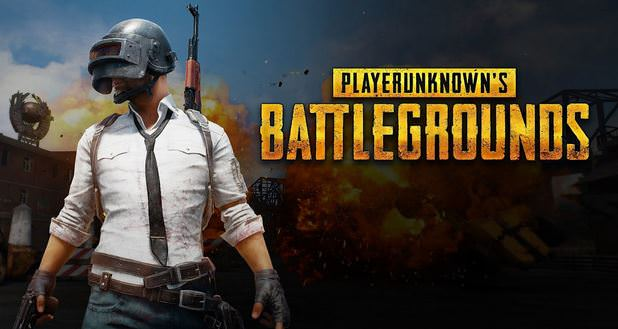

**Data Description** -

In a **PUBG game**, up to **100 players start in each match** (**matchId**). Players can be on **teams** (**groupId**) which **get ranked** at the end of the game (**winPlacePerc**) based on how many other teams are still alive when they are eliminated. In game, players can pick up different munitions, revive downed-but-not-out (knocked) teammates, drive vehicles, swim, run, shoot, and experience all of the consequences -- such as falling too far or running themselves over and eliminating themselves.

You are provided with a **large number of anonymized PUBG game stats**, formatted so that **each row contains one player's post-game stats**. The data comes from matches of all types: solos, duos, squads, and custom; there is **no guarantee of there being 100 players per match, nor at most 4 player per group**.

**You must create a model which predicts players' finishing placement based on their final stats, on a scale from 1 (first place) to 0 (last place).**


## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn import preprocessing, linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from google.colab import drive
import gc
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Mounting Google Drive

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


## Reading the Data

In [ ]:
# Train data
Train = pd.read_csv('/content/drive/MyDrive/PUBG-finish-placement-prediction/Train_data.csv')
df_train = Train.copy()
df_train.head()

Id         groupId  ... winPoints  winPlacePerc
0  dd1abf8c8dea06  874c02ce3e8883  ...         0        0.0612
1  fc609144bd1681  d64fdc706a385e  ...         0        0.0769
2  4162f2e84a85fd  4ca0a106852af3  ...      1523        0.8276
3  77f9aefafd79b7  2a80a0320990bc  ...      1532        0.7857
4  5eacc6e736d0b3  17b1572f2599d5  ...      1569        0.8519

[5 rows x 29 columns]

In [ ]:
# Test data
Test = pd.read_csv('/content/drive/MyDrive/PUBG-finish-placement-prediction/Test_data.csv')
df_test = Test.copy()
df_test.head()

Id         groupId  ... winPoints  winPlacePerc
0  3819823802f48a  f0fd309f8ca457  ...      1455        0.6522
1  aa439f81e8792b  c83cc7dcb364cd  ...      1517        0.9032
2  5284c4d2d9183c  7bfd6bd25707fd  ...         0        0.2766
3  c15709d34368e3  4e6a9999406061  ...         0        0.2963
4  d749a74a11eb0a  f2a554bfed0c58  ...         0        0.5714

[5 rows x 29 columns]

### Data Fields

**Id** - Player’s Id

**groupId** - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.

**matchId** - ID to identify match. There are no matches that are in both the training and testing set.

**assists** - Number of enemy players this player damaged that were killed by teammates.

**boosts** - Number of boost items used.

**damageDealt** - Total damage dealt. Note: Self inflicted damage is subtracted.

**DBNOs** - Number of enemy players knocked.

**headshotKills** - Number of enemy players killed with headshots.

**heals** - Number of healing items used.

**killPlace** - Ranking in match of number of enemy players killed.

**killPoints** - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.

(The Elo rating system is a method for calculating the relative skill levels of players in zero-sum games such as chess)

**kills** - Number of enemy players killed.

**killStreaks** - Max number of enemy players killed in a short amount of time.

**longestKill** - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.

**matchDuration** - Duration of match in seconds.

**matchType** - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.

**maxPlace** - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.

**numGroups** - Number of groups we have data for in the match.

**rankPoints** - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.

**revives** - Number of times this player revived teammates.

**rideDistance** - Total distance traveled in vehicles measured in meters.

**roadKills** - Number of kills while in a vehicle.

**swimDistance** - Total distance traveled by swimming measured in meters.

**teamKills** - Number of times this player killed a teammate.

**vehicleDestroys** - Number of vehicles destroyed.

**walkDistance** - Total distance traveled on foot measured in meters.

**weaponsAcquired** - Number of weapons picked up.

**winPoints** - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.

**winPlacePerc** - The **target of prediction**. This is a **percentile winning placement**, where **1 corresponds to 1st place**, and **0 corresponds to last place in the match**. It is **calculated off of maxPlace**, not numGroups, so it is possible to have missing chunks in a match.

## Shape of the Data

In [ ]:
# Shape of Train data
df_train.shape

(3557572, 29)

The Train data consists of 35,57,572 rows and 29 columns

In [ ]:
# Shape of Test data
df_test.shape

(889394, 29)

The Test data consists of 8,89,394 rows and 29 columns

## Concise summary of the DataFrame (index, column dtypes, non-null values and memory usage)

In [ ]:
# Train
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3557572 entries, 0 to 3557571
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

In [ ]:
# Test
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889394 entries, 0 to 889393
Data columns (total 29 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Id               889394 non-null  object 
 1   groupId          889394 non-null  object 
 2   matchId          889394 non-null  object 
 3   assists          889394 non-null  int64  
 4   boosts           889394 non-null  int64  
 5   damageDealt      889394 non-null  float64
 6   DBNOs            889394 non-null  int64  
 7   headshotKills    889394 non-null  int64  
 8   heals            889394 non-null  int64  
 9   killPlace        889394 non-null  int64  
 10  killPoints       889394 non-null  int64  
 11  kills            889394 non-null  int64  
 12  killStreaks      889394 non-null  int64  
 13  longestKill      889394 non-null  float64
 14  matchDuration    889394 non-null  int64  
 15  matchType        889394 non-null  object 
 16  maxPlace         889394 non-null  int6

## Checking for Null values

In [ ]:
# Train
df_train.isna().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

There is a null value in winPlacePerc.

In [ ]:
# Deleting the null value at winPlacePerc
df_train.dropna(inplace=True)
df_train.isna().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       0
dtype: int64

In [ ]:
# Test
df_test.isna().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       0
dtype: int64

Now, there are no null values in the dataset.

## Statistical summary of numerical columns

In [ ]:
# Train
df_train.describe().T

count         mean  ...        75%      max
assists          3557571.0     0.233868  ...     0.0000     22.0
boosts           3557571.0     1.107268  ...     2.0000     28.0
damageDealt      3557571.0   130.722348  ...   186.0000   6375.0
DBNOs            3557571.0     0.657947  ...     1.0000     40.0
headshotKills    3557571.0     0.226727  ...     0.0000     64.0
heals            3557571.0     1.370260  ...     2.0000     80.0
killPlace        3557571.0    47.593951  ...    71.0000    101.0
killPoints       3557571.0   504.878249  ...  1171.0000   2152.0
kills            3557571.0     0.924800  ...     1.0000     72.0
killStreaks      3557571.0     0.544045  ...     1.0000     20.0
longestKill      3557571.0    22.980796  ...    21.3300   1094.0
matchDuration    3557571.0  1579.495777  ...  1851.0000   2237.0
maxPlace         3557571.0    44.503889  ...    49.0000    100.0
numGroups        3557571.0    43.006301  ...    47.0000    100.0
rankPoints       3557571.0   892.222105  ...  1500.0000   5827.0
revives          3557571.0     0.164687  ...     0.0000     39.0
rideDistance     3557571.0   606.247392  ...     0.2196  40710.0
roadKills        3557571.0     0.003517  ...     0.0000     14.0
swimDistance     3557571.0     4.512578  ...     0.0000   3823.0
teamKills        3557571.0     0.023879  ...     0.0000     12.0
vehicleDestroys  3557571.0     0.007917  ...     0.0000      5.0
walkDistance     3557571.0  1154.575464  ...  1977.0000  15370.0
weaponsAcquired  3557571.0     3.661500  ...     5.0000    236.0
winPoints        3557571.0   606.245727  ...  1495.0000   2002.0
winPlacePerc     3557571.0     0.472903  ...     0.7407      1.0

[25 rows x 8 columns]

In [ ]:
# Test
df_test.describe().T

count         mean  ...         75%      max
assists          889394.0     0.233604  ...     0.00000     21.0
boosts           889394.0     1.105470  ...     2.00000     33.0
damageDealt      889394.0   130.696445  ...   185.90000   6616.0
DBNOs            889394.0     0.657592  ...     1.00000     53.0
headshotKills    889394.0     0.227188  ...     0.00000     41.0
heals            889394.0     1.369699  ...     2.00000     57.0
killPlace        889394.0    47.620998  ...    71.00000    100.0
killPoints       889394.0   505.517781  ...  1172.00000   2170.0
kills            889394.0     0.924718  ...     1.00000     65.0
killStreaks      889394.0     0.543597  ...     1.00000     18.0
longestKill      889394.0    23.064818  ...    21.28000   1011.0
matchDuration    889394.0  1579.550855  ...  1851.00000   2237.0
maxPlace         889394.0    44.507844  ...    49.00000    100.0
numGroups        889394.0    43.012805  ...    47.00000    100.0
rankPoints       889394.0   891.163098  ...  1500.00000   5910.0
revives          889394.0     0.164549  ...     0.00000     20.0
rideDistance     889394.0   605.589461  ...     0.11035  28450.0
roadKills        889394.0     0.003414  ...     0.00000     18.0
swimDistance     889394.0     4.496305  ...     0.00000   2718.0
teamKills        889394.0     0.023827  ...     0.00000     10.0
vehicleDestroys  889394.0     0.007922  ...     0.00000      5.0
walkDistance     889394.0  1152.788738  ...  1975.00000  25780.0
weaponsAcquired  889394.0     3.656442  ...     5.00000    167.0
winPoints        889394.0   607.318424  ...  1495.00000   2013.0
winPlacePerc     889394.0     0.472497  ...     0.74070      1.0

[25 rows x 8 columns]

## Statistical summary of non-numerical columns

In [ ]:
# Train
df_train.describe(include = ['O']).T

count   unique             top     freq
Id         3557571  3557571  ddd46897d343cd        1
groupId    3557571  1839256  14d6b54cdec6bc       60
matchId    3557571    47964  b46fbe9b4a7558       93
matchType  3557571       16       squad-fpp  1405482

In [ ]:
# Test
df_test.describe(include = ['O']).T

count  unique             top    freq
Id         889394  889394  bef40474cf3024       1
groupId    889394  728747  b8275198faa03b      17
matchId    889394   47933  1b59729d23a572      37
matchType  889394      16       squad-fpp  350704

## Exploratory Data Analysis (EDA)


### Pearson's correlation of Attributes with Target (winPlacePerc)

In [ ]:
cor_mat = df_train.corr()
df_corr_win = pd.DataFrame({"Correlation_with_winPlacePerc": cor_mat['winPlacePerc'].values},
                  index=cor_mat['winPlacePerc'].index)
df_corr_win

Correlation_with_winPlacePerc
assists                               0.299663
boosts                                0.634140
damageDealt                           0.440836
DBNOs                                 0.279796
headshotKills                         0.277775
heals                                 0.427908
killPlace                            -0.719063
killPoints                            0.012525
kills                                 0.420087
killStreaks                           0.377551
longestKill                           0.410180
matchDuration                        -0.005285
maxPlace                              0.037187
numGroups                             0.039445
rankPoints                            0.013837
revives                               0.240558
rideDistance                          0.342800
roadKills                             0.035121
swimDistance                          0.149607
teamKills                             0.016021
vehicleDestroys                       0.073471
walkDistance                          0.810840
weaponsAcquired                       0.584204
winPoints                             0.006731
winPlacePerc                          1.000000

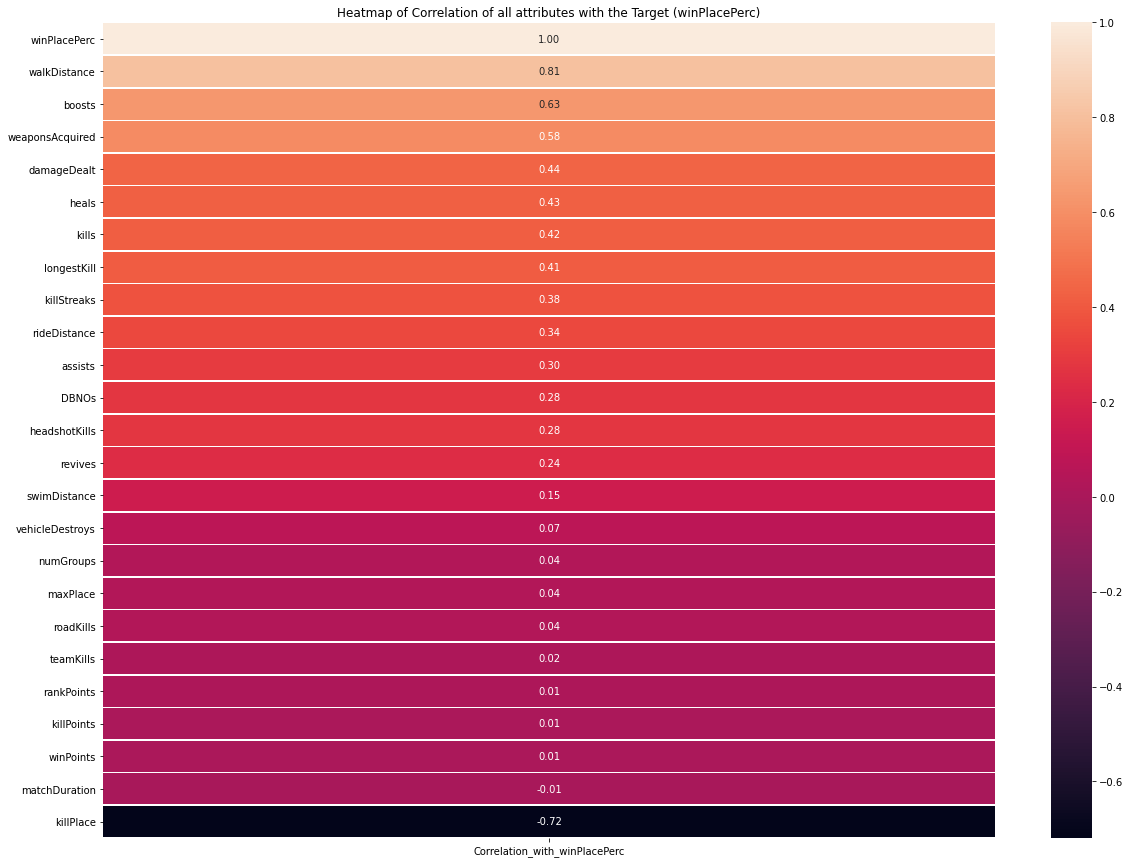

In [ ]:
plt.figure(figsize=(20, 15))
ax = sns.heatmap(df_corr_win.sort_values(by='Correlation_with_winPlacePerc',ascending=False), annot=True, linewidths=.6, fmt= '.2f')
plt.title('Heatmap of Correlation of all attributes with the Target (winPlacePerc)')
plt.show()

In terms of the target variable (winPlacePerc), there are a few variables high medium to high correlation. The highest positive correlation is walkDistance and the highest negative the killPlace.

There are only 2 negatively correlated variables with the target (killPlace and matchDuration).

The top-5 most positively correlated variables with the target are -
1. walkDistance
2. boosts
3. weaponsAcquired
4. damageDealt
5. heals

In [ ]:
# Deleting the unnecessary data to reduce memory usage
del cor_mat

In [ ]:
# Invoking Garbage Collector

collected = gc.collect()
print("Garbage collector: collected",
		"%d objects." % collected)

Garbage collector: collected 148 objects.


### Distribution of Numerical Columns

Creating a dataframe of all numerical columns

In [ ]:
df_train_numeric = df_train.drop(columns=['Id', 'groupId', 'matchId', 'matchType'])
df_train_numeric.head()

assists  boosts  damageDealt  ...  weaponsAcquired  winPoints  winPlacePerc
0        0       0          0.0  ...                0          0        0.0612
1        0       0          0.0  ...                1          0        0.0769
2        0       2         22.6  ...                3       1523        0.8276
3        0       1        181.3  ...                2       1532        0.7857
4        1       9        587.1  ...                6       1569        0.8519

[5 rows x 25 columns]

Plotting the distribution of numerical columns

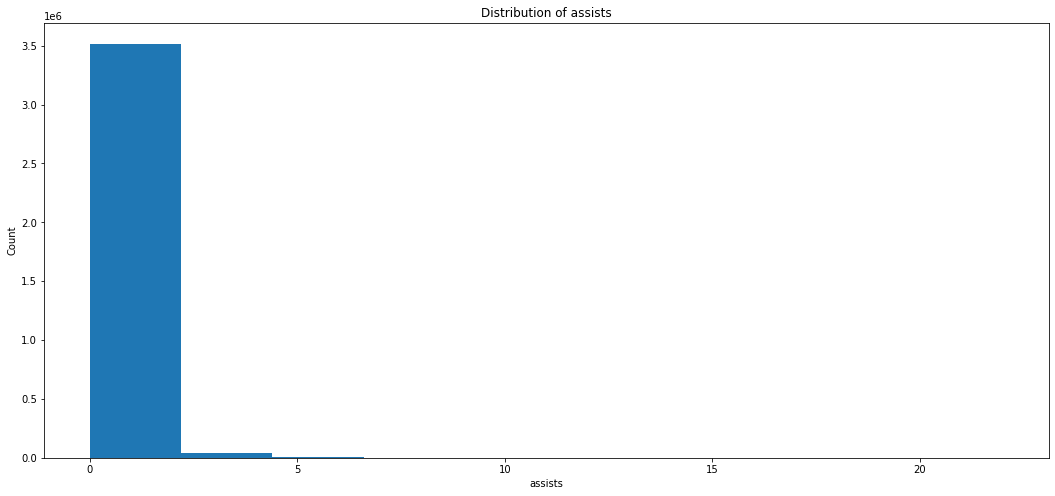


Average number of assists is 0.23, minimum is 0.00 and the maximum 22.00, 99% of players have assists = 3.00.



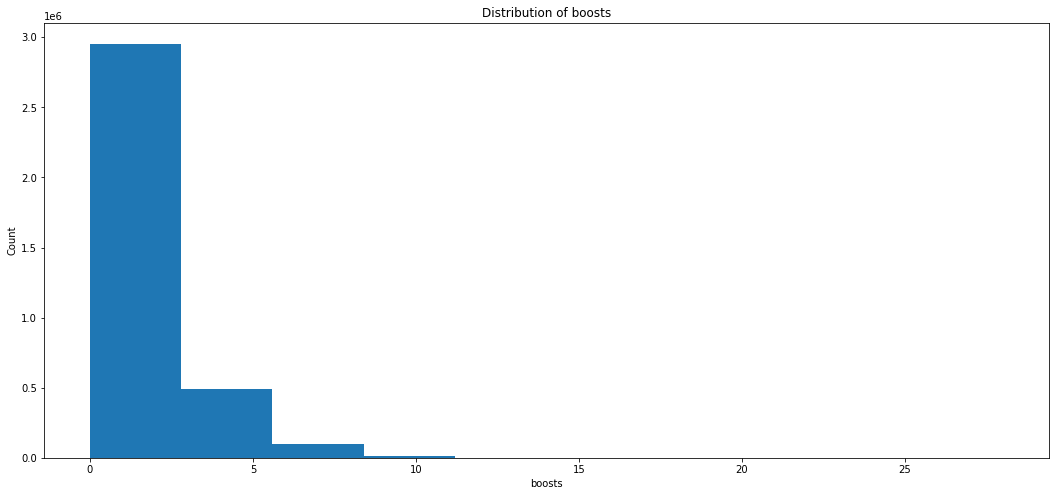


Average number of boosts is 1.11, minimum is 0.00 and the maximum 28.00, 99% of players have boosts = 7.00.



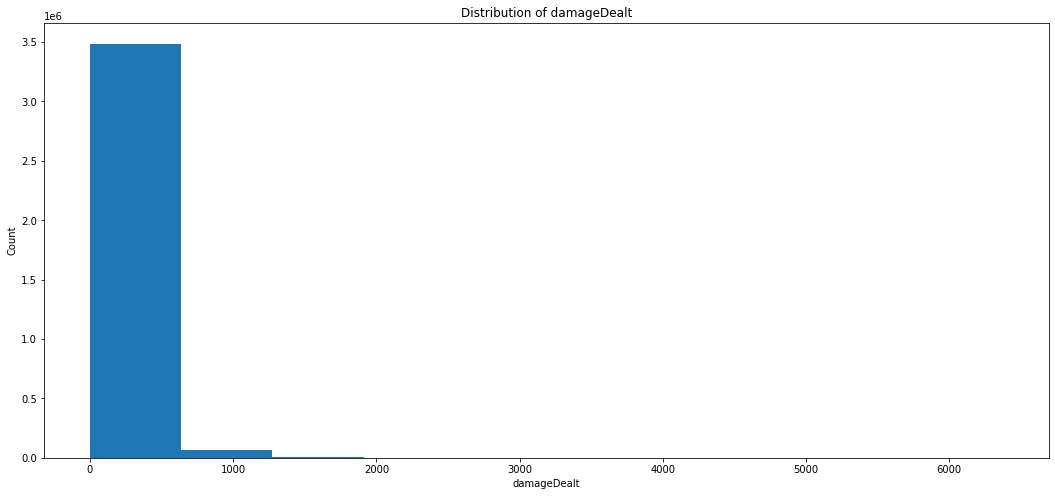


Average number of damageDealt is 130.72, minimum is 0.00 and the maximum 6375.00, 99% of players have damageDealt = 775.70.



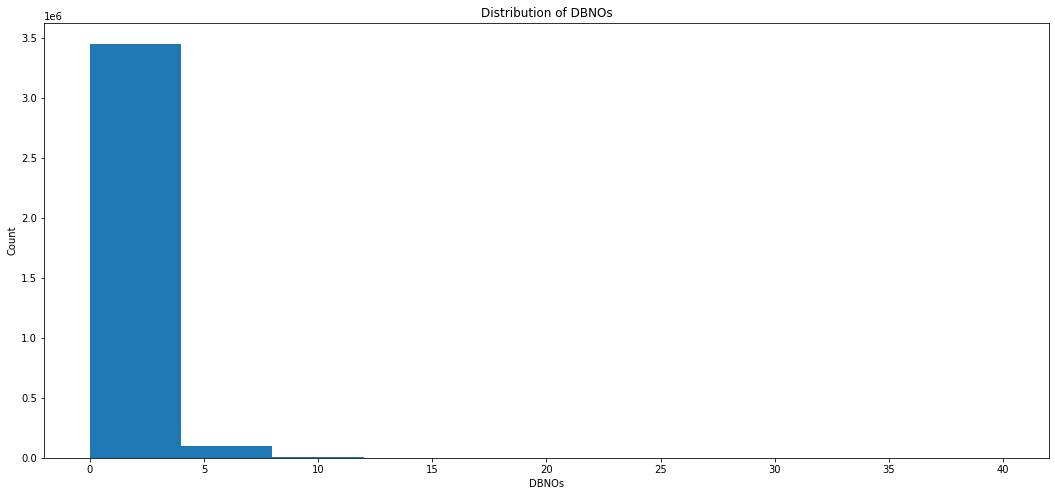


Average number of DBNOs is 0.66, minimum is 0.00 and the maximum 40.00, 99% of players have DBNOs = 5.00.



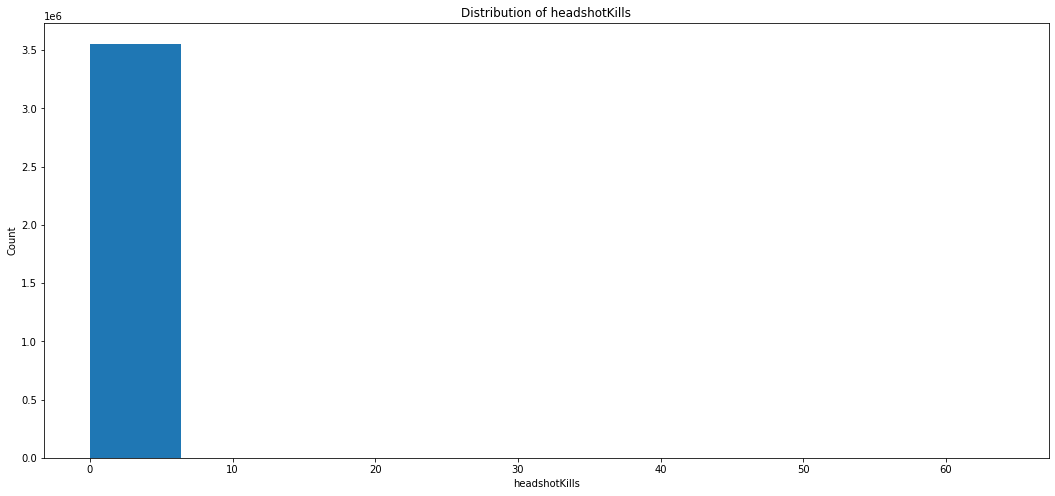


Average number of headshotKills is 0.23, minimum is 0.00 and the maximum 64.00, 99% of players have headshotKills = 3.00.



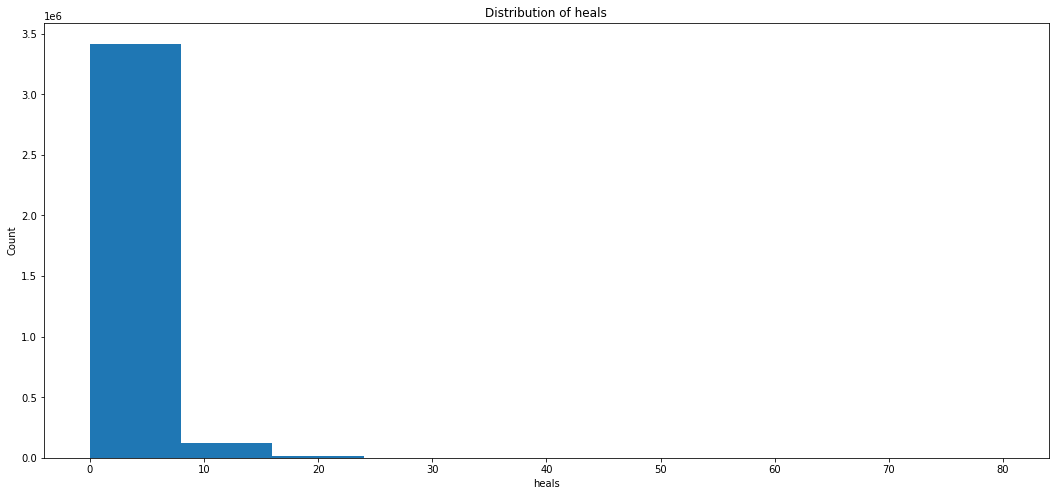


Average number of heals is 1.37, minimum is 0.00 and the maximum 80.00, 99% of players have heals = 12.00.



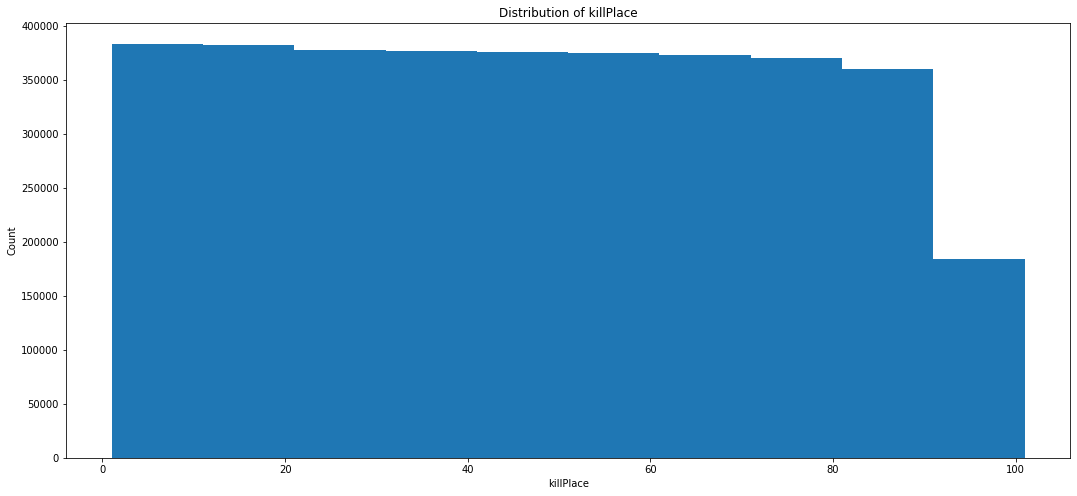


Average number of killPlace is 47.59, minimum is 1.00 and the maximum 101.00, 99% of players have killPlace = 96.00.



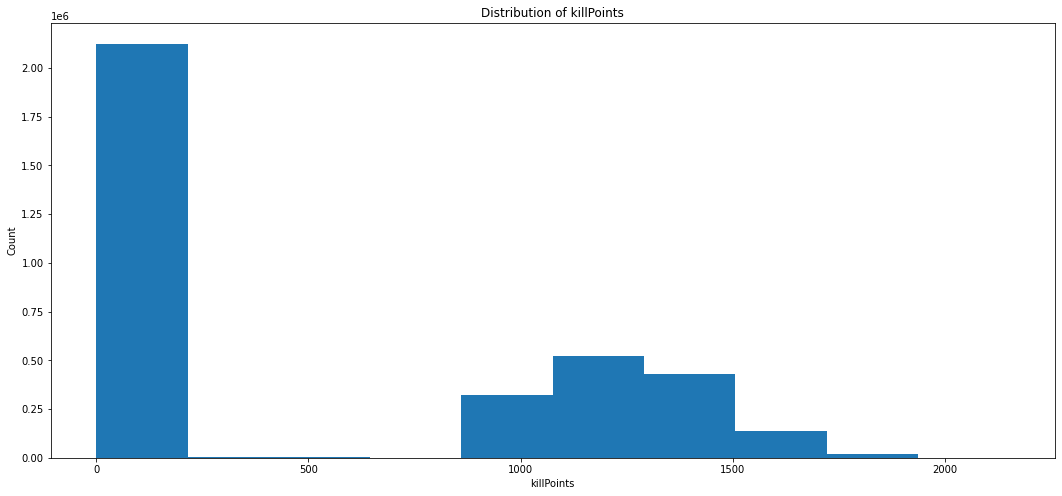


Average number of killPoints is 504.88, minimum is 0.00 and the maximum 2152.00, 99% of players have killPoints = 1671.00.



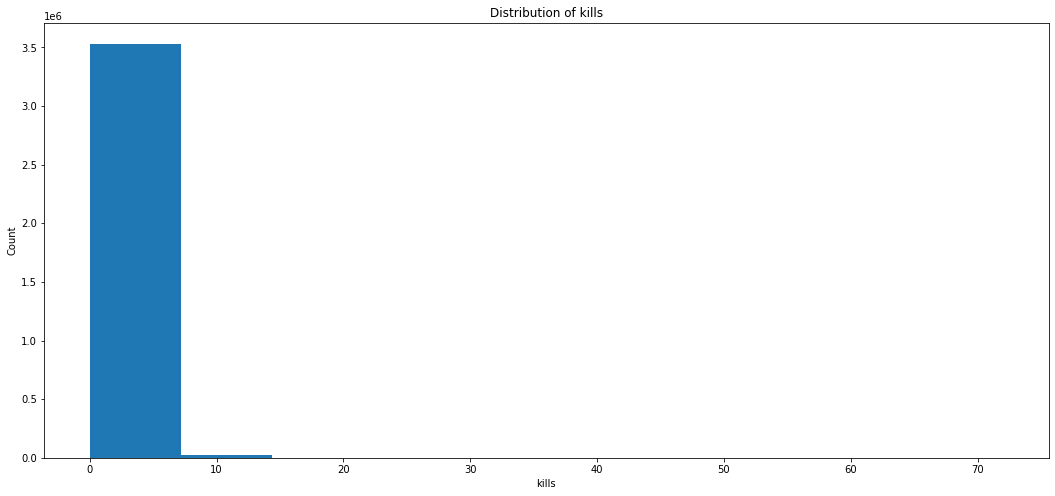


Average number of kills is 0.92, minimum is 0.00 and the maximum 72.00, 99% of players have kills = 7.00.



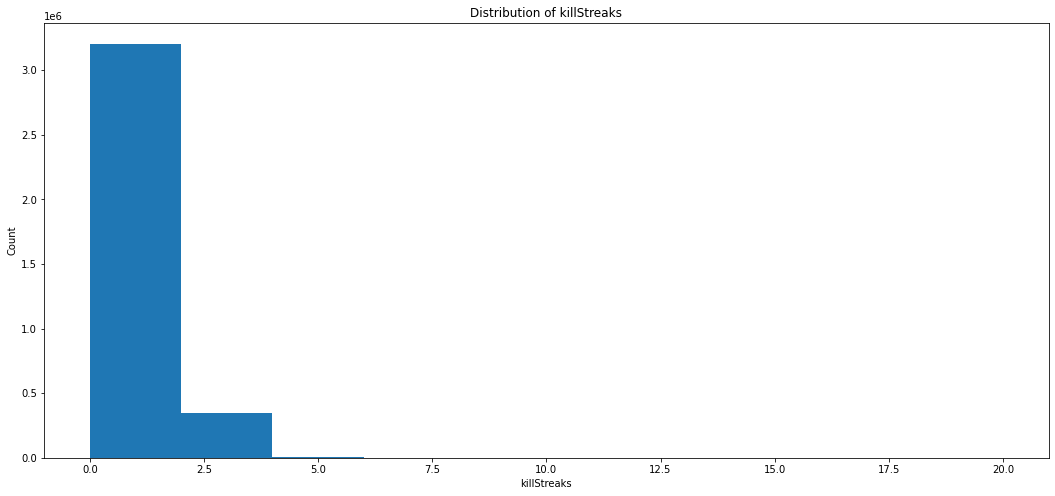


Average number of killStreaks is 0.54, minimum is 0.00 and the maximum 20.00, 99% of players have killStreaks = 3.00.



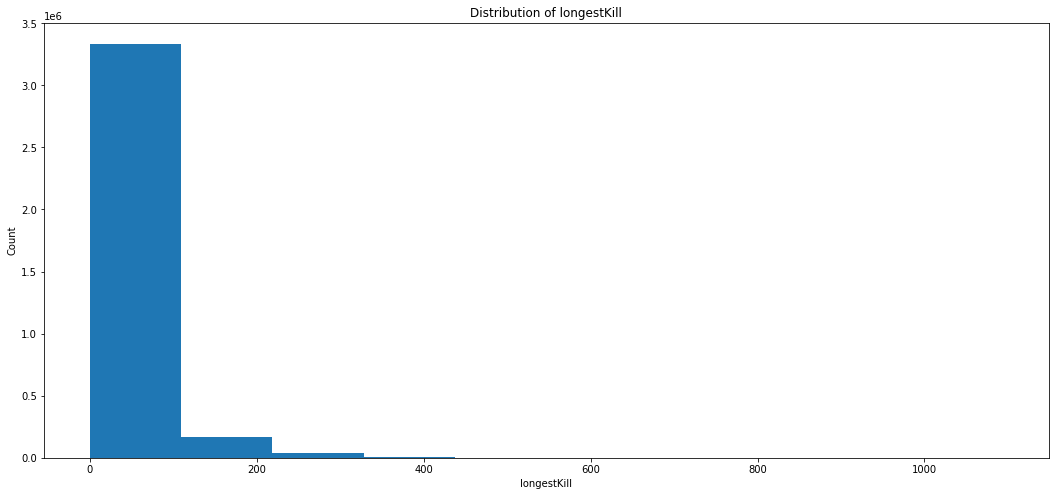


Average number of longestKill is 22.98, minimum is 0.00 and the maximum 1094.00, 99% of players have longestKill = 243.70.



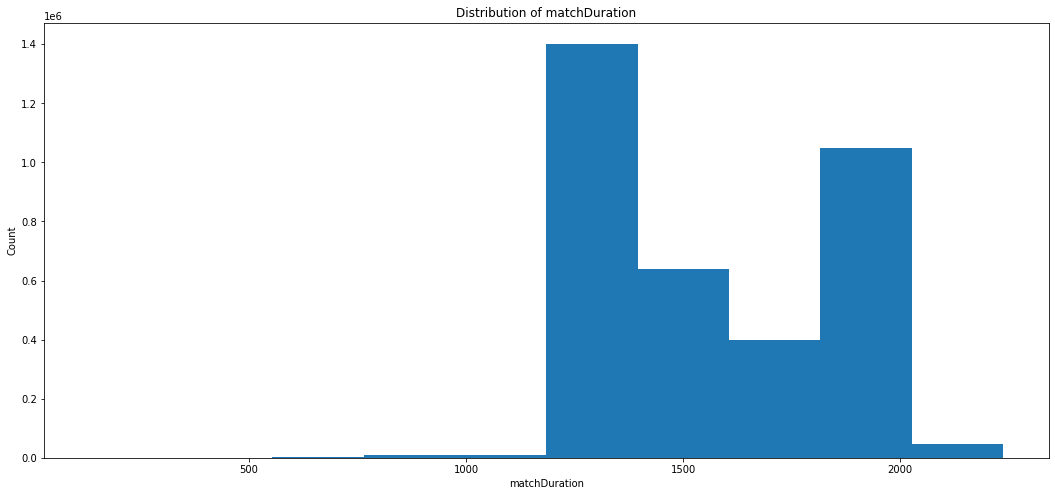


Average number of matchDuration is 1579.50, minimum is 133.00 and the maximum 2237.00, 99% of players have matchDuration = 2052.00.



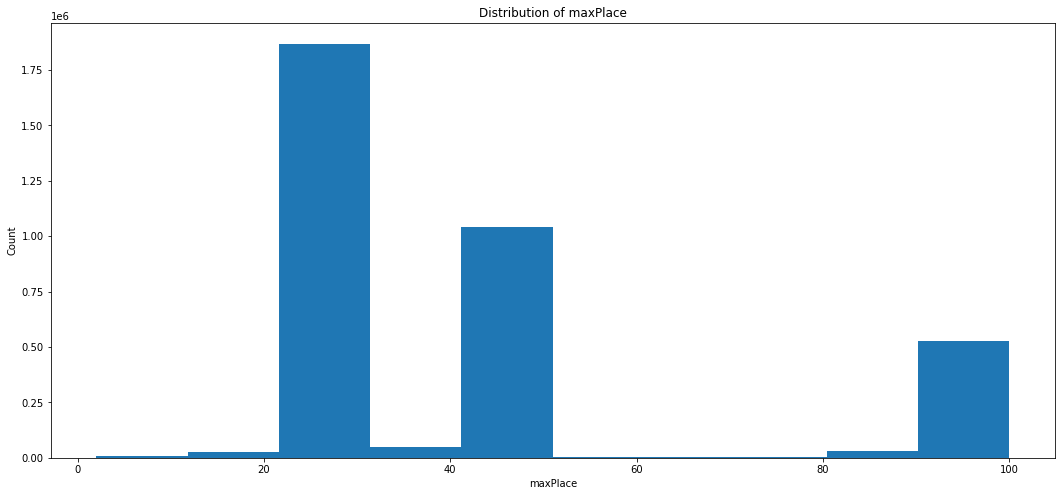


Average number of maxPlace is 44.50, minimum is 2.00 and the maximum 100.00, 99% of players have maxPlace = 99.00.



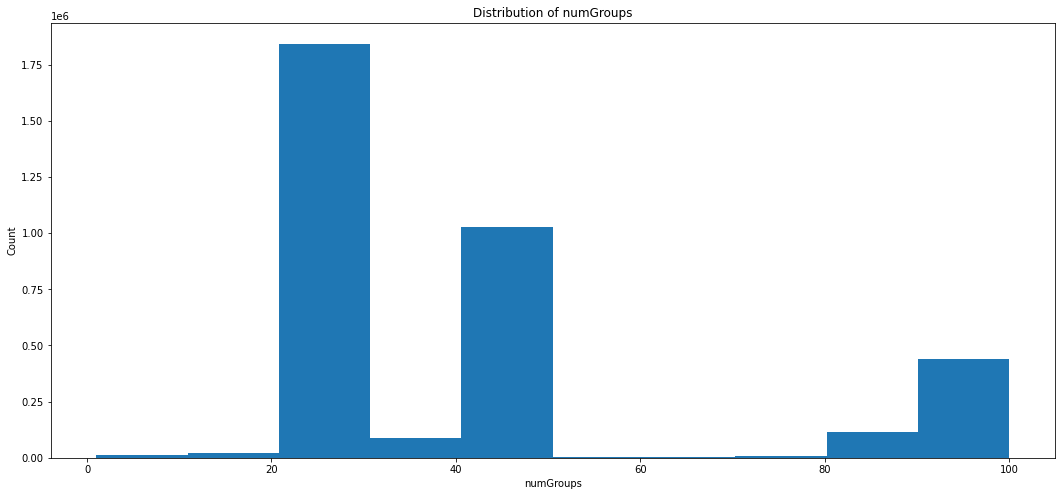


Average number of numGroups is 43.01, minimum is 1.00 and the maximum 100.00, 99% of players have numGroups = 97.00.



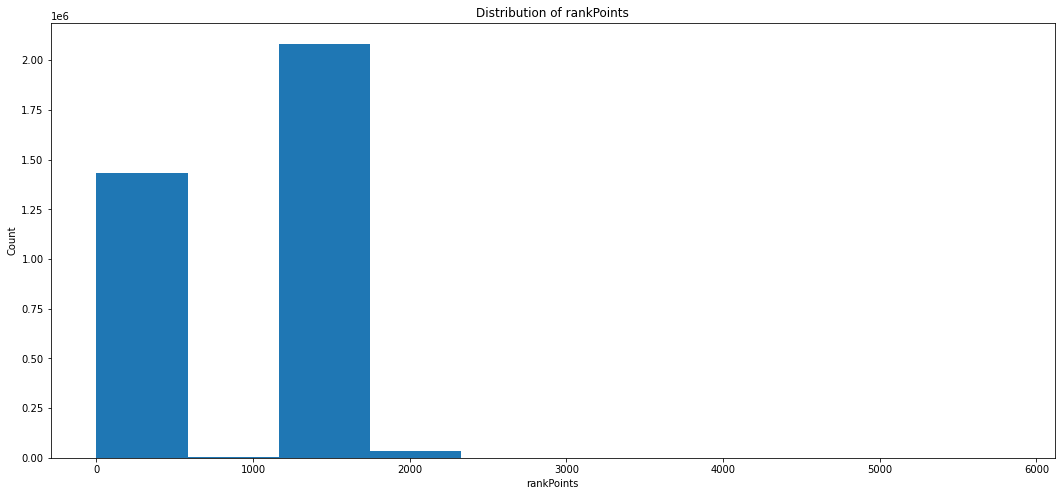


Average number of rankPoints is 892.22, minimum is -1.00 and the maximum 5827.00, 99% of players have rankPoints = 1749.00.



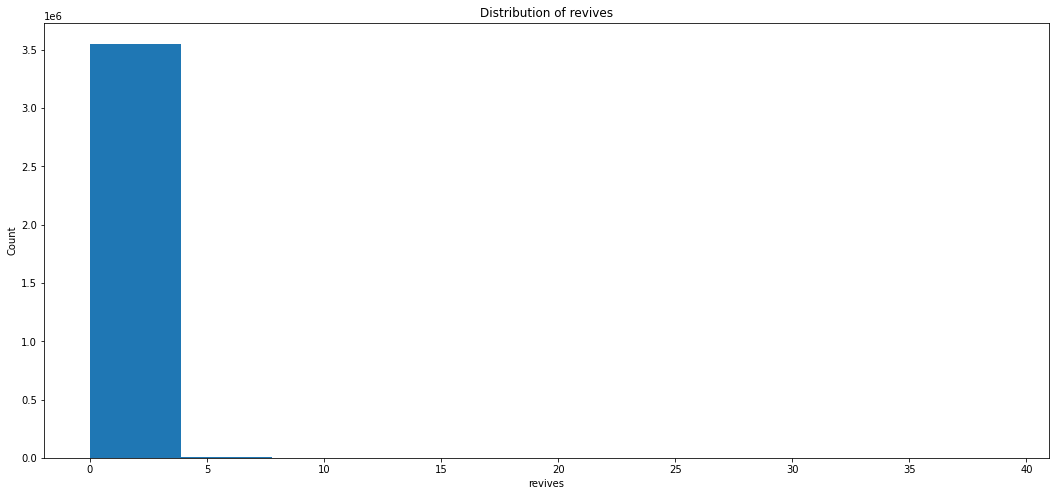


Average number of revives is 0.16, minimum is 0.00 and the maximum 39.00, 99% of players have revives = 2.00.



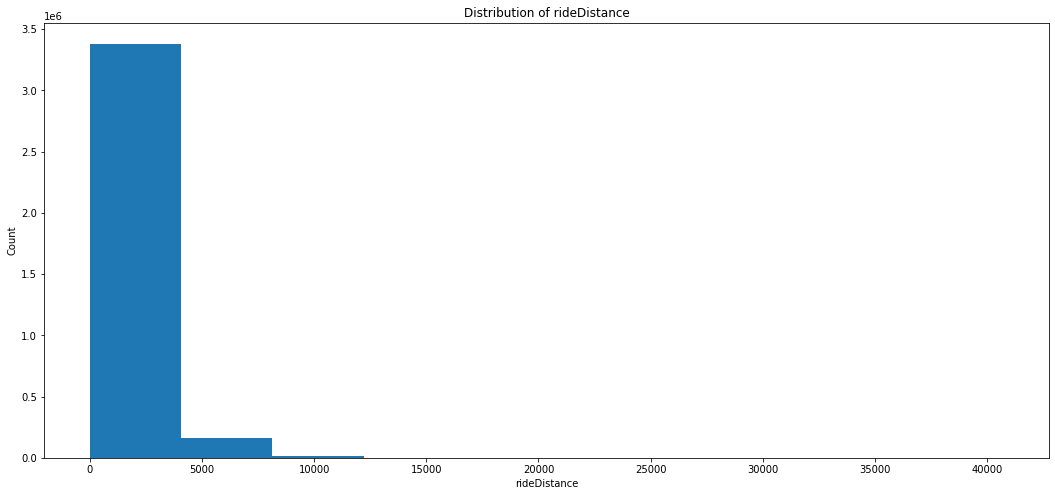


Average number of rideDistance is 606.25, minimum is 0.00 and the maximum 40710.00, 99% of players have rideDistance = 6968.00.



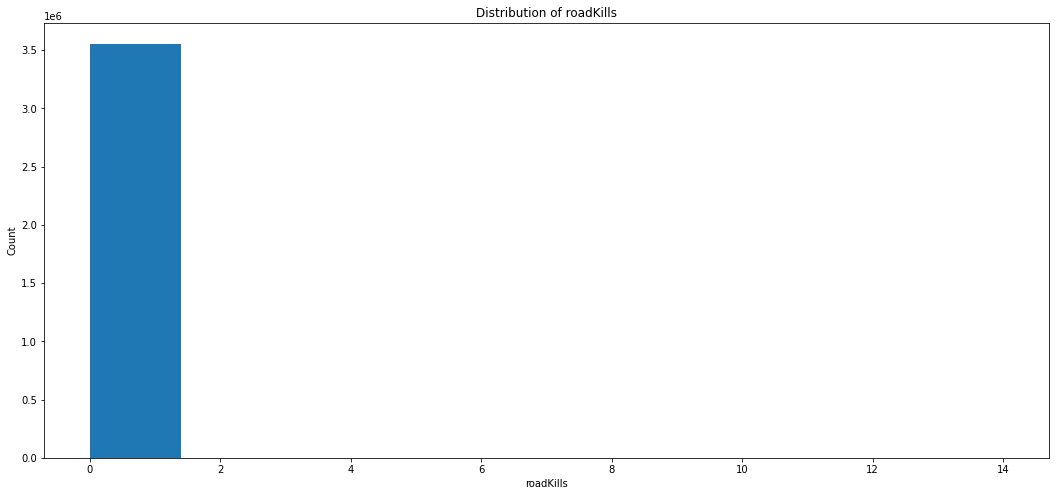


Average number of roadKills is 0.00, minimum is 0.00 and the maximum 14.00, 99% of players have roadKills = 0.00.



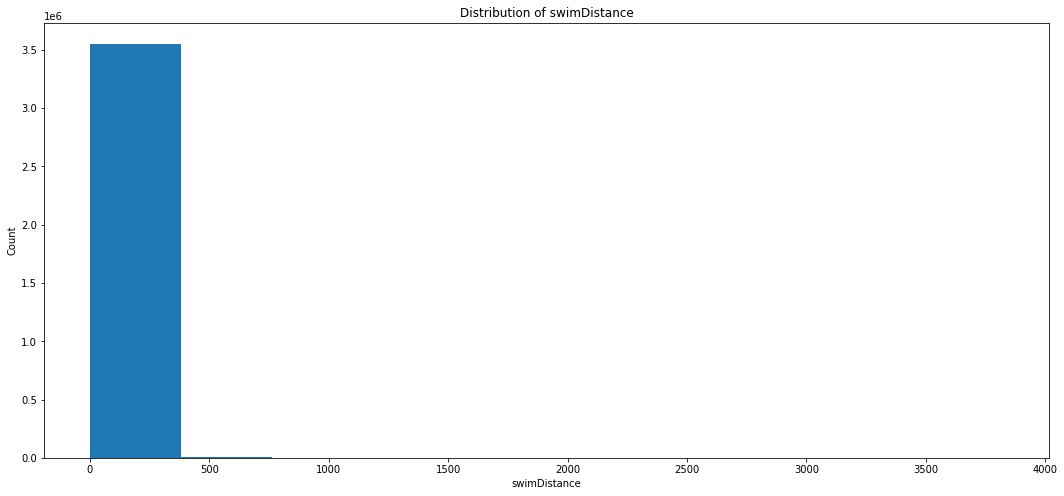


Average number of swimDistance is 4.51, minimum is 0.00 and the maximum 3823.00, 99% of players have swimDistance = 123.00.



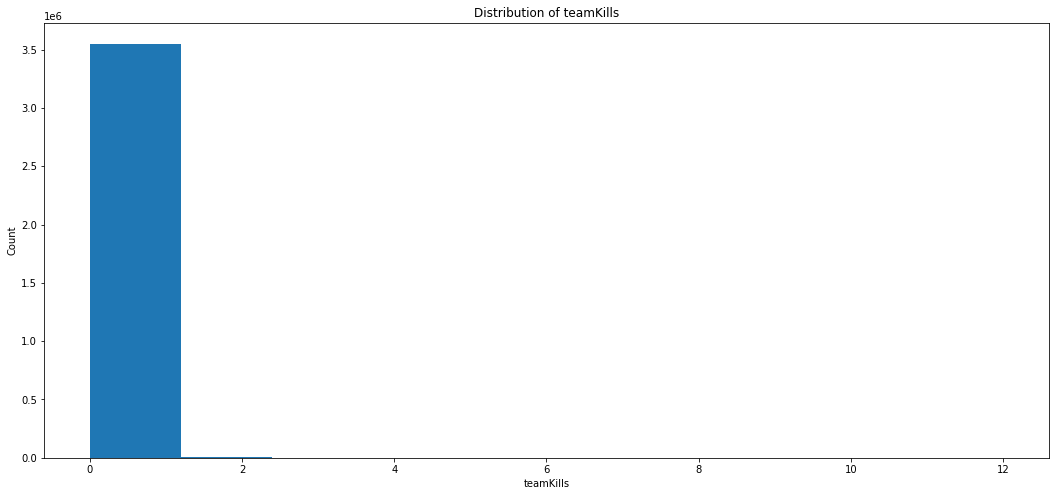


Average number of teamKills is 0.02, minimum is 0.00 and the maximum 12.00, 99% of players have teamKills = 1.00.



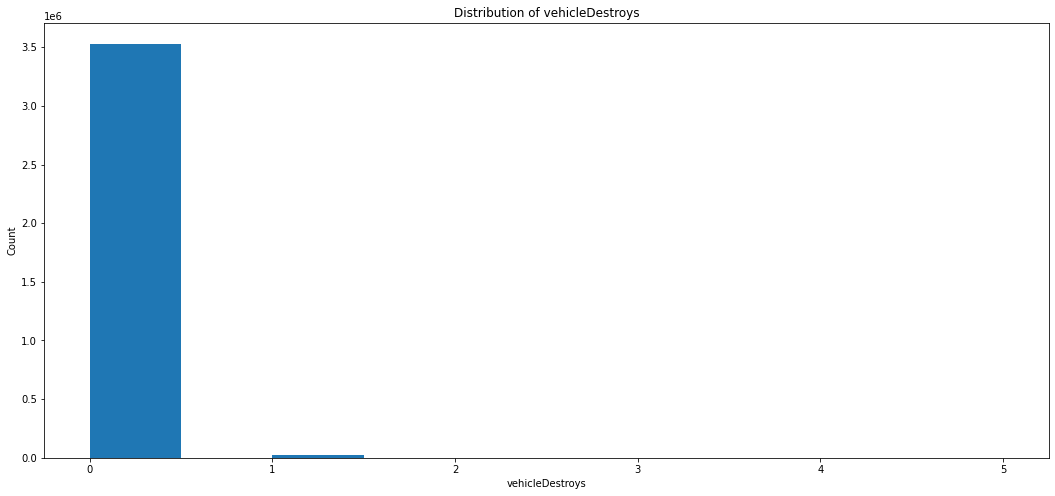


Average number of vehicleDestroys is 0.01, minimum is 0.00 and the maximum 5.00, 99% of players have vehicleDestroys = 0.00.



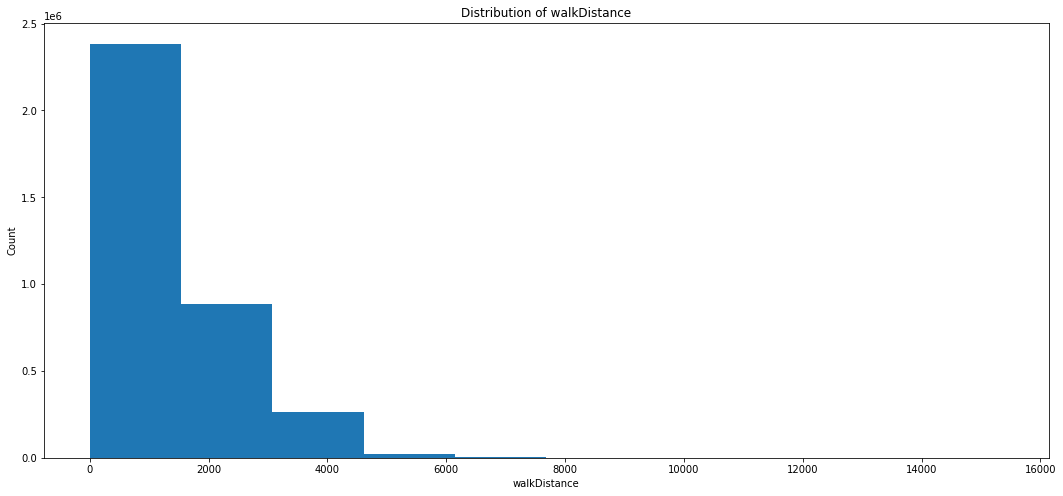


Average number of walkDistance is 1154.58, minimum is 0.00 and the maximum 15370.00, 99% of players have walkDistance = 4401.00.



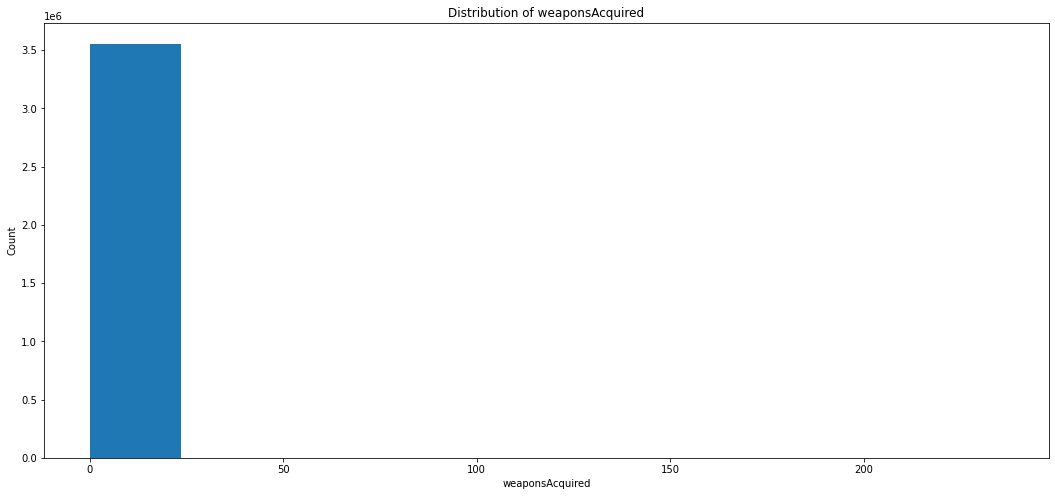


Average number of weaponsAcquired is 3.66, minimum is 0.00 and the maximum 236.00, 99% of players have weaponsAcquired = 10.00.



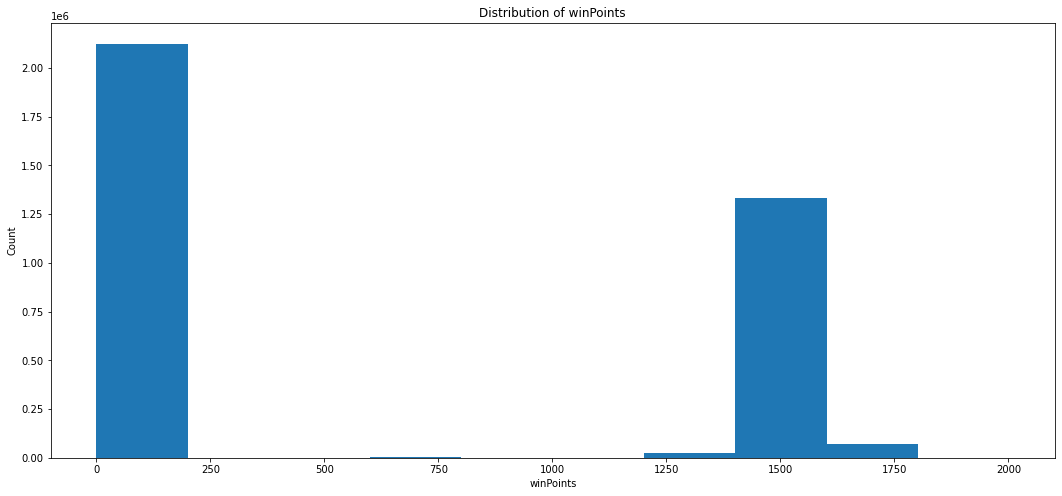


Average number of winPoints is 606.25, minimum is 0.00 and the maximum 2002.00, 99% of players have winPoints = 1633.00.



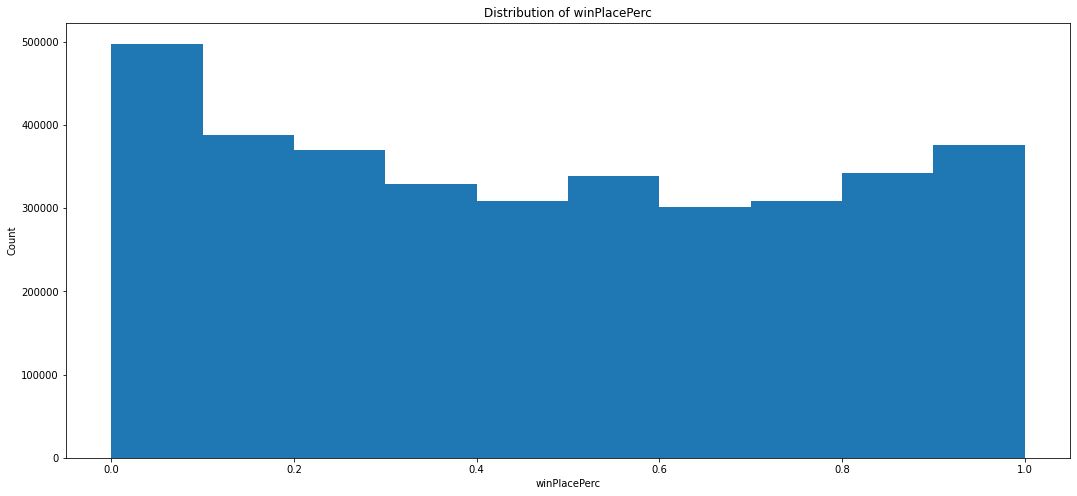


Average number of winPlacePerc is 0.47, minimum is 0.00 and the maximum 1.00, 99% of players have winPlacePerc = 1.00.



In [ ]:
for i, col in enumerate(df_train_numeric.columns):
    plt.figure(i,figsize=(18,8))
    plt.hist(df_train_numeric[col])
    plt.title("Distribution of "+ col)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()
    print("\nAverage number of {} is {:.2f}, minimum is {:.2f} and the maximum {:.2f}, 99% of players have {} = {:.2f}.\n" 
      .format(col, df_train[col].mean(), df_train[col].min(), df_train[col].max(), col, df_train[col].quantile(0.99)))

### Pairplot for comparision of columns with the Target Variable

Creating a dataframe of all numerical columns excluding winPlacePerc

In [ ]:
df_train_pair = df_train_numeric.drop(columns=['winPlacePerc'])
df_train_pair.head()

assists  boosts  damageDealt  ...  walkDistance  weaponsAcquired  winPoints
0        0       0          0.0  ...         208.1                0          0
1        0       0          0.0  ...         141.1                1          0
2        0       2         22.6  ...        2630.0                3       1523
3        0       1        181.3  ...        2617.0                2       1532
4        1       9        587.1  ...        2444.0                6       1569

[5 rows x 24 columns]

Plotting the comparison of numerical columns with winPlacePerc

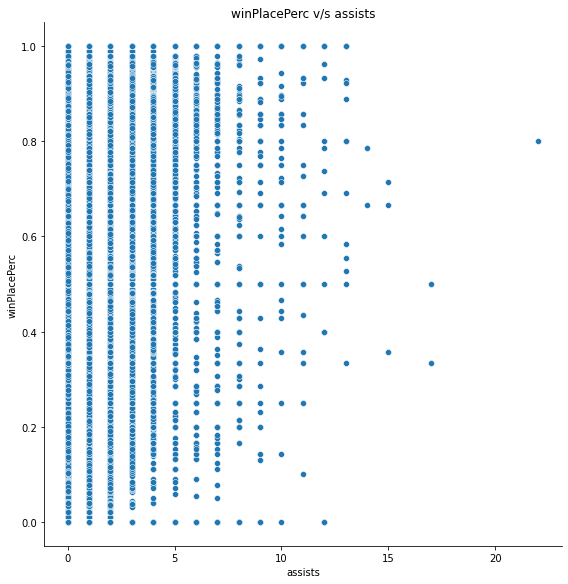

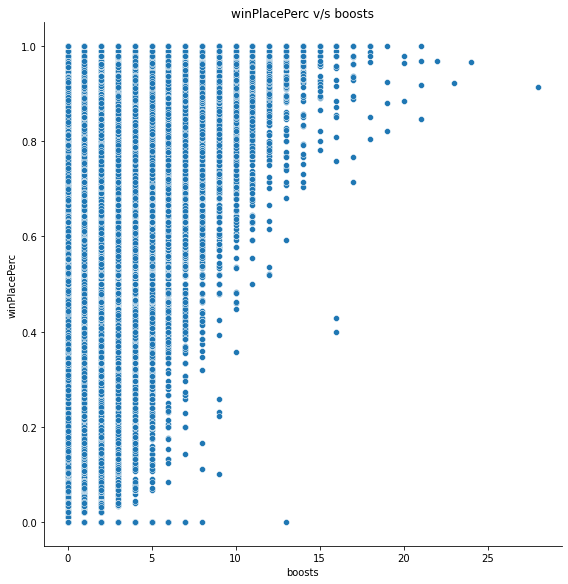

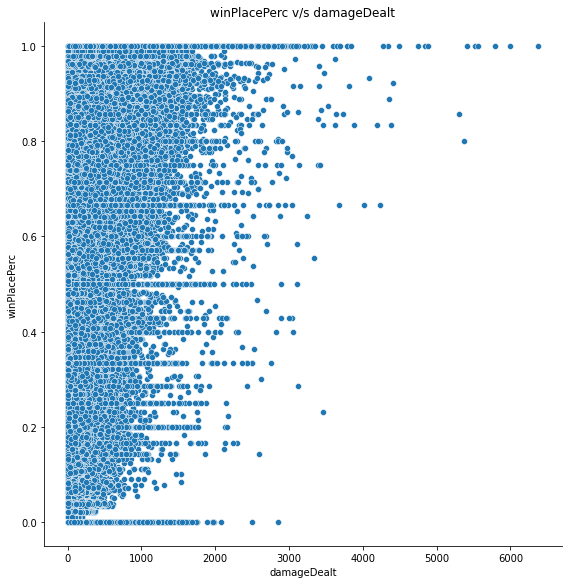

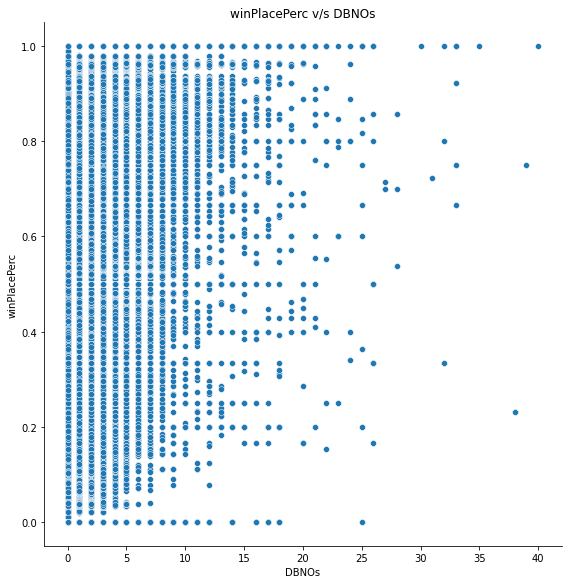

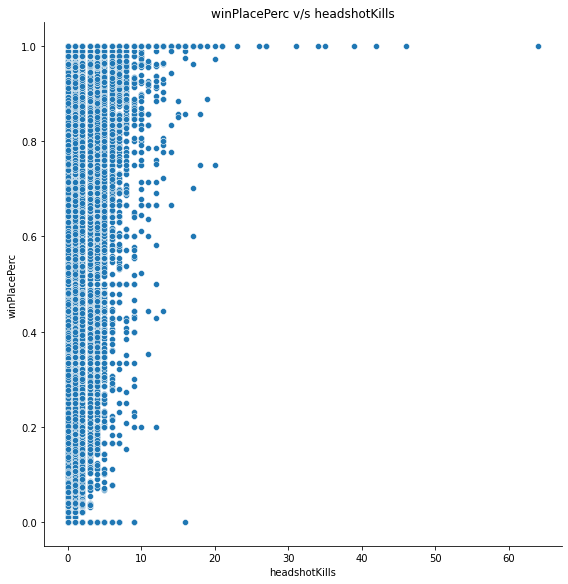

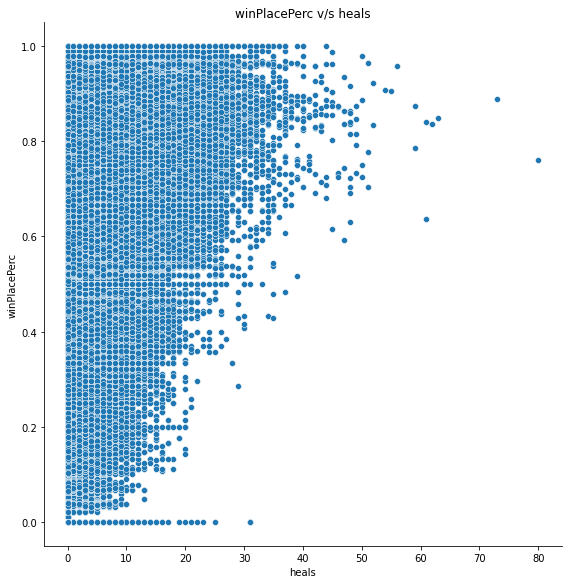

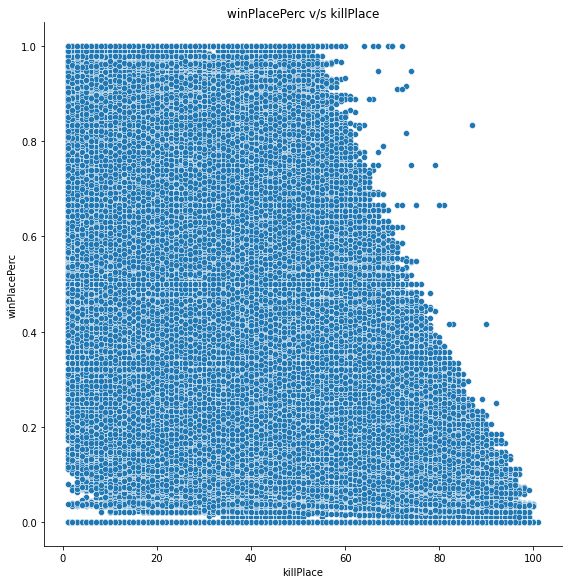

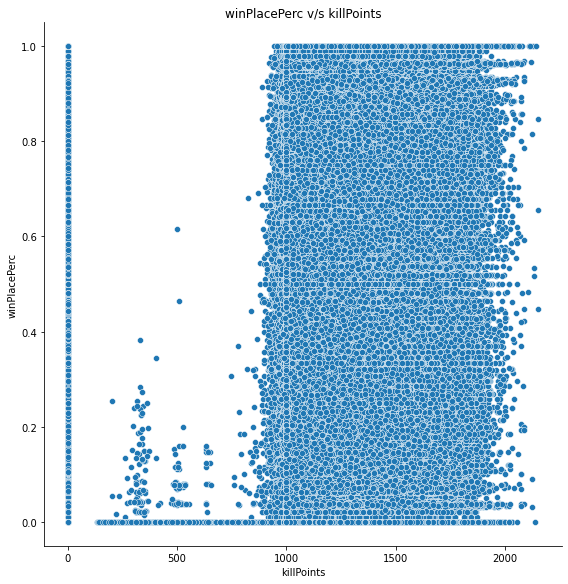

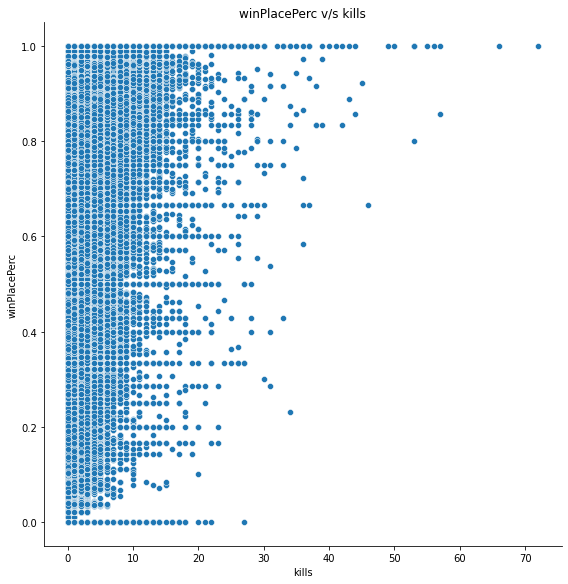

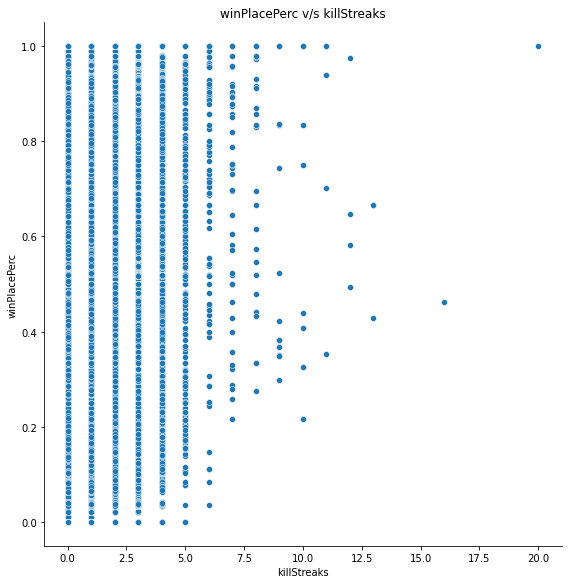

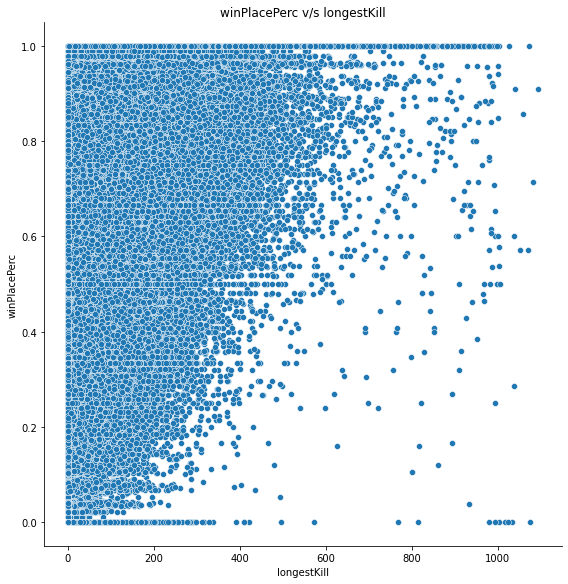

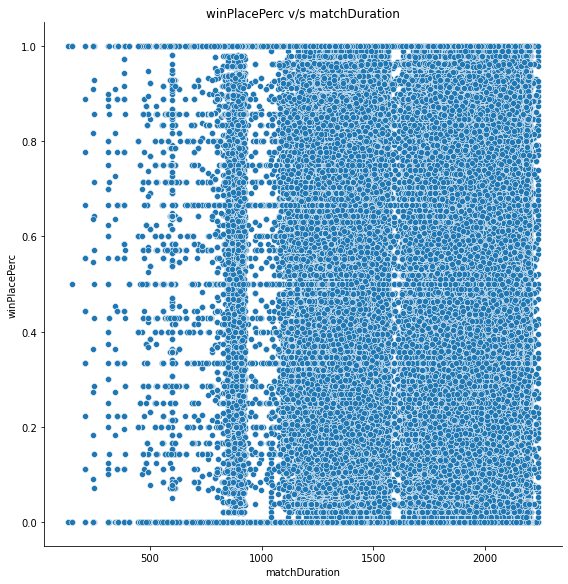

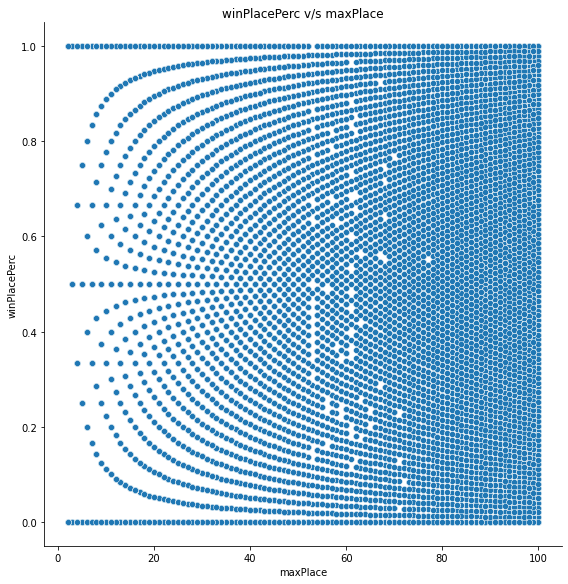

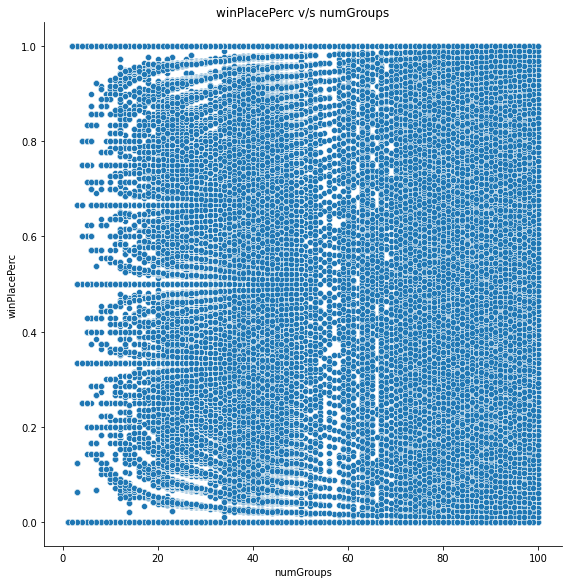

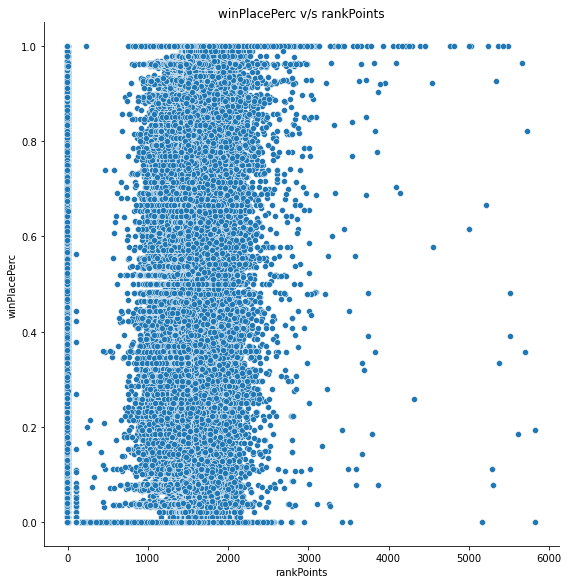

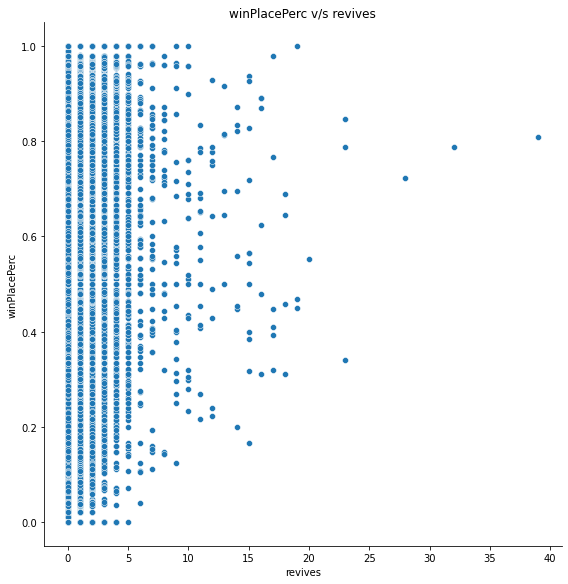

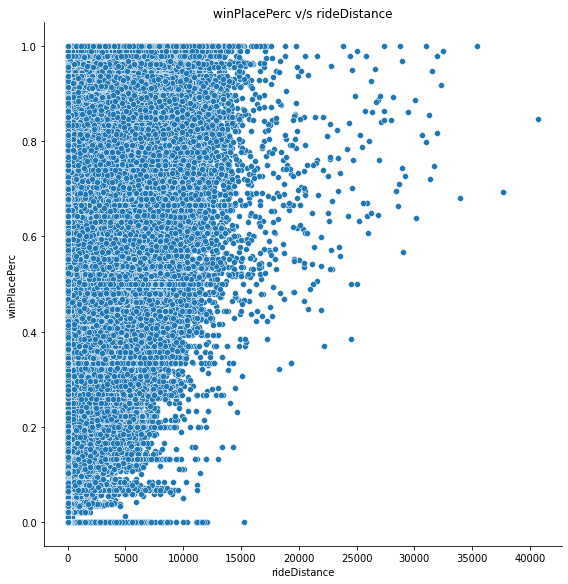

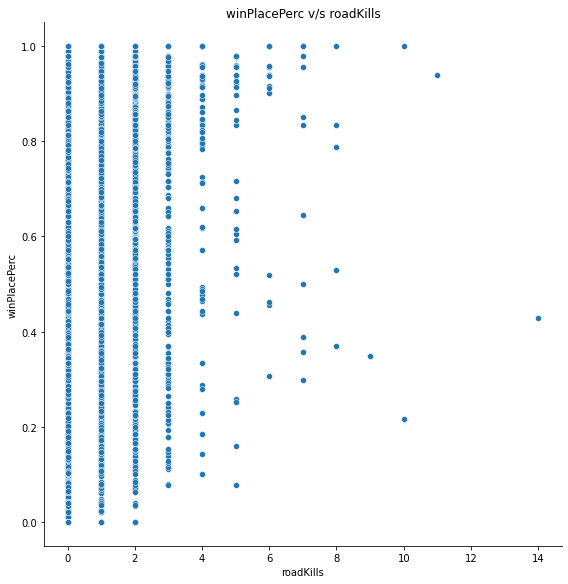

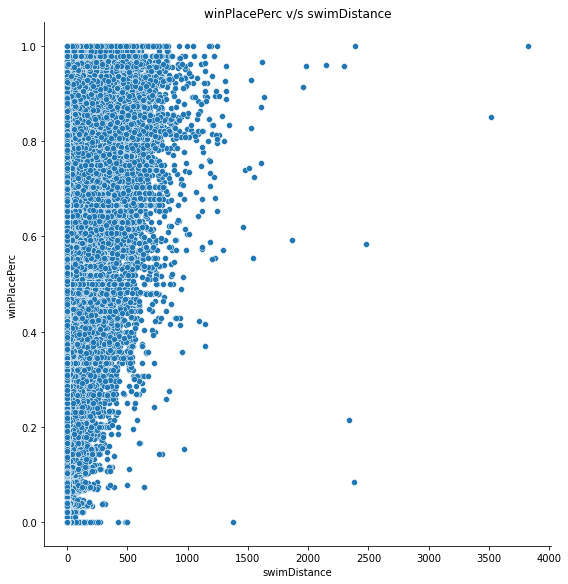

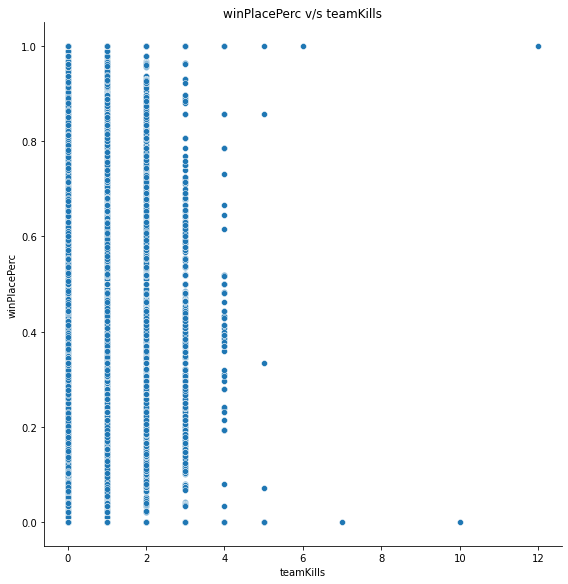

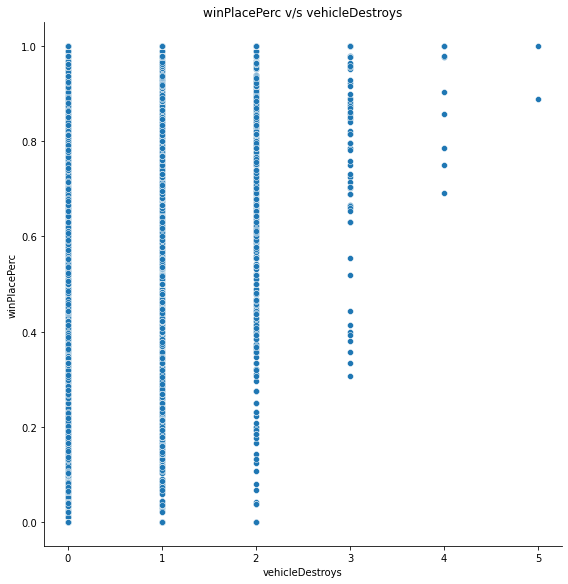

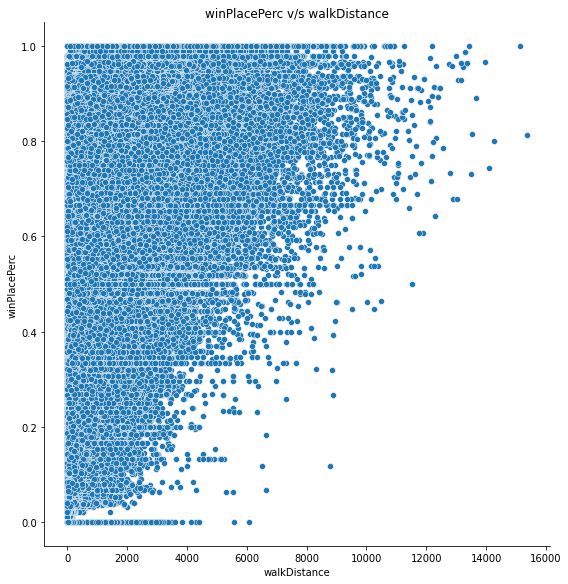

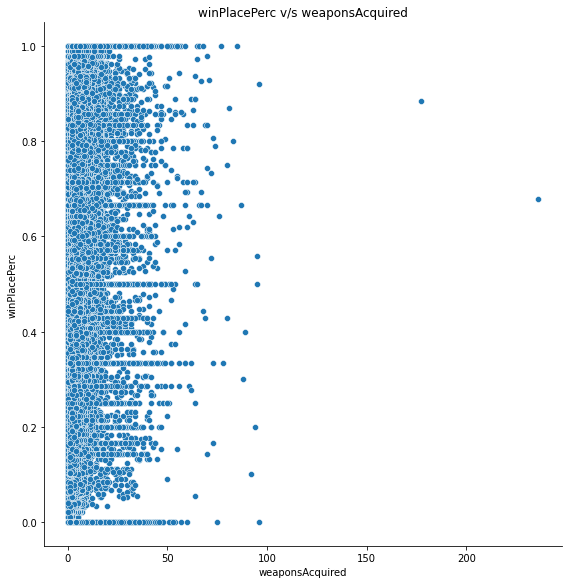

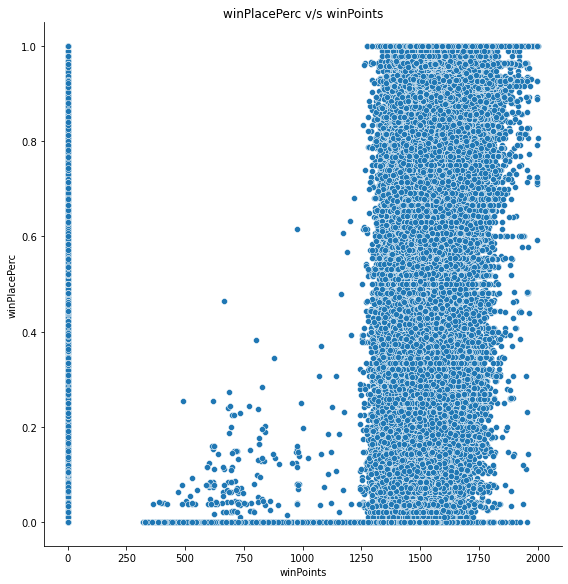

In [ ]:
for i, col in enumerate(df_train_pair.columns):
    sns.pairplot(height=8,x_vars=col,y_vars='winPlacePerc', data=df_train)
    plt.title('winPlacePerc' + ' v/s ' + col)
    plt.show()

In [ ]:
# Deleting the dataframe df_train_pair to reduce memory usage
del df_train_pair

In [ ]:
# Invoking Garbage Collector

collected = gc.collect()
print("Garbage collector: collected",
		"%d objects." % collected)

Garbage collector: collected 17252 objects.


### Barplot and Pie Chart w.r.t Match Types

Removing custom matchTypes(crashfpp, flaretpp, crashtpp, flarefpp) and selecting Traditional matchTypes only from the Train data

In [ ]:
df_train.shape

(3557571, 29)

In [ ]:
df_train = df_train[~df_train['matchType'].isin(['crashfpp', 'flaretpp', 'crashtpp', 'flarefpp'])]
df_train.head()

Id         groupId  ... winPoints  winPlacePerc
0  dd1abf8c8dea06  874c02ce3e8883  ...         0        0.0612
1  fc609144bd1681  d64fdc706a385e  ...         0        0.0769
2  4162f2e84a85fd  4ca0a106852af3  ...      1523        0.8276
3  77f9aefafd79b7  2a80a0320990bc  ...      1532        0.7857
4  5eacc6e736d0b3  17b1572f2599d5  ...      1569        0.8519

[5 rows x 29 columns]

In [ ]:
df_train.shape

(3549665, 29)

Removing custom matchTypes(crashfpp, flaretpp, crashtpp, flarefpp) and selecting Traditional matchTypes only from the Test data

In [ ]:
df_test.shape

(889394, 29)

In [ ]:
df_test = df_test[~df_test['matchType'].isin(['crashfpp', 'flaretpp', 'crashtpp', 'flarefpp'])]
df_test.head()

Id         groupId  ... winPoints  winPlacePerc
0  3819823802f48a  f0fd309f8ca457  ...      1455        0.6522
1  aa439f81e8792b  c83cc7dcb364cd  ...      1517        0.9032
2  5284c4d2d9183c  7bfd6bd25707fd  ...         0        0.2766
3  c15709d34368e3  4e6a9999406061  ...         0        0.2963
4  d749a74a11eb0a  f2a554bfed0c58  ...         0        0.5714

[5 rows x 29 columns]

In [ ]:
df_test.shape

(887419, 29)

In [ ]:
m_types = df_train.loc[:,"matchType"].value_counts().to_frame().reset_index()
m_types.columns = ["Type","Count"]
m_types

Type    Count
0          squad-fpp  1405482
1            duo-fpp   797110
2              squad   500935
3           solo-fpp   429103
4                duo   250834
5               solo   145893
6   normal-squad-fpp    13736
7     normal-duo-fpp     4406
8    normal-solo-fpp     1339
9       normal-squad      420
10       normal-solo      253
11        normal-duo      154

Plotting the Match Types

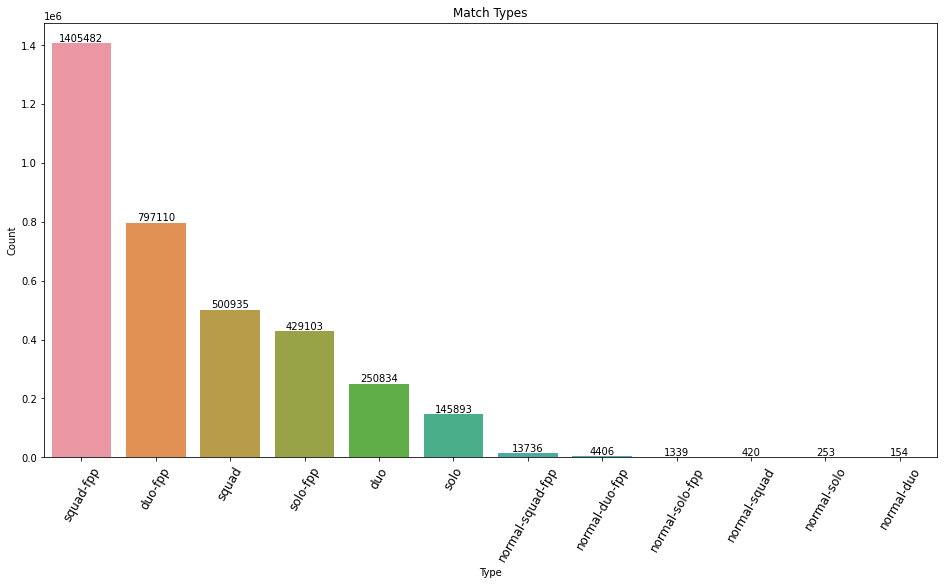

In [ ]:
plt.figure(figsize=(16,8))
ticks = m_types.Type.values
plt.xticks(rotation = 60)
ax = sns.barplot(x="Type", y="Count", data=m_types)
ax.set_xticklabels(ticks, fontsize=12)
ax.set_title("Match Types")
for index, row in m_types.iterrows():
  ax.text(row.name,row.Count, round(row.Count,2), verticalalignment='bottom', ha="center")
plt.show()

The graph above shows that the most popular game modes are squad-fpp, duo-fpp and squad.

In PUBG there are essentially three main modes of game: **Solo, Duo and Squad**.

In a squad mode, you play in a group of 4 players.

In a duo mode, you play in a group of 2 players.

In a solo mode, you play as a single player.

Here we can see that the match types are further broken down taking into account view modes:

FPP - First Person Perspective

TPP - Third Person Perspective

Now we aggregate all these individual types into three main categories (squad, duo and solo).

In [ ]:
m_types2 = df_train.loc[:,"matchType"].value_counts().to_frame()
aggregated_squads = m_types2.loc[["squad-fpp", "squad", "normal-squad-fpp", "normal-squad"],"matchType"].sum()
aggregated_duos = m_types2.loc[["duo-fpp","duo", "normal-duo-fpp", "normal-duo"],"matchType"].sum()
aggregated_solo = m_types2.loc[["solo-fpp","solo", "normal-solo-fpp", "normal-solo"],"matchType"].sum()
aggregated_mt = pd.DataFrame([aggregated_squads,aggregated_duos,aggregated_solo], index=["squad","duo","solo"], columns =["count"])
aggregated_mt

count
squad  1920573
duo    1052504
solo    576588

Matches played w.r.t. Match Types (in %)

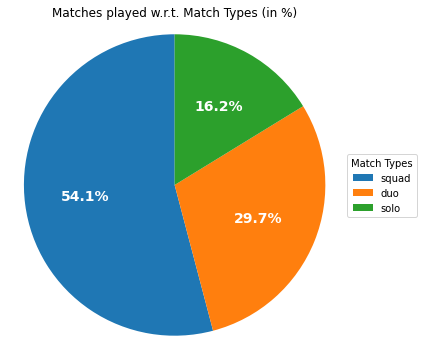

In [ ]:
fig1, ax1 = plt.subplots(figsize=(6, 6))
labels = ['squad', 'duo', 'solo']

wedges, texts, autotexts = ax1.pie(aggregated_mt["count"],textprops=dict(color="w"), autopct='%1.1f%%', startangle=90)

ax1.axis('equal')
ax1.set_title("Matches played w.r.t. Match Types (in %)")
ax1.legend(wedges, labels,
          title="Match Types",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=14, weight="bold")
plt.show()

The pie chart above shows that around 54% of all the matches were played in squad mode, 30% of all the matches were played in duo mode and 16% of all the matches were played in solo mode.

In [ ]:
# Deleting the unnecessary data
del m_types
del m_types2
del aggregated_squads
del aggregated_duos
del aggregated_solo
del aggregated_mt

In [ ]:
# Invoking Garbage Collector

collected = gc.collect()
print("Garbage collector: collected",
		"%d objects." % collected)

Garbage collector: collected 6337 objects.


### Outlier Detection and Treatment

#### Boxplot of numeric columns to check outliers

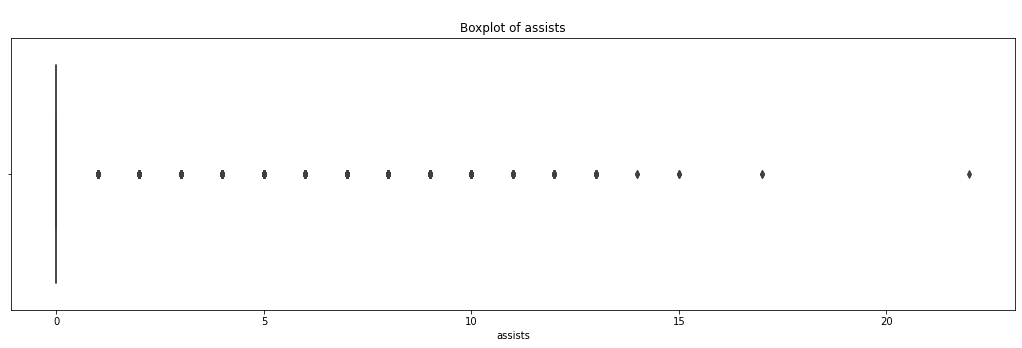

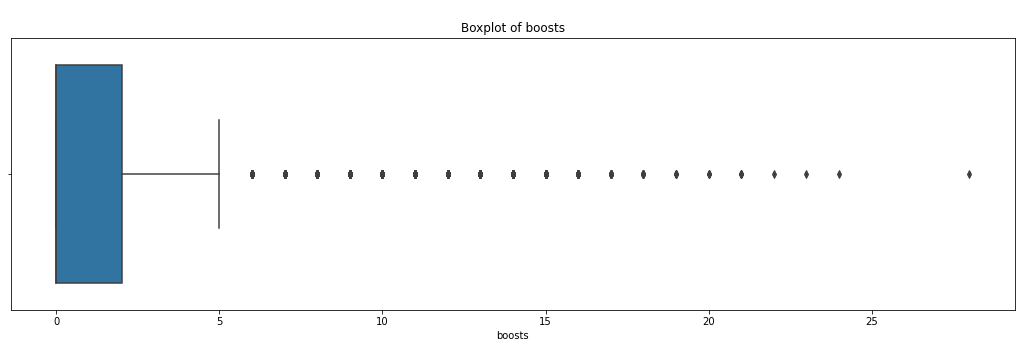

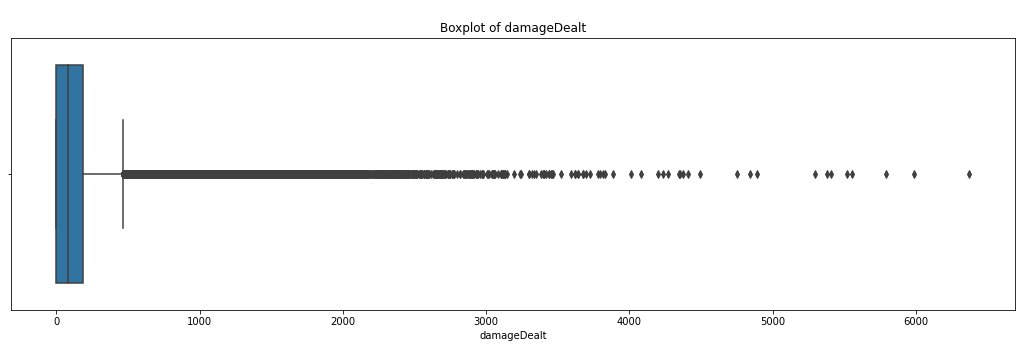

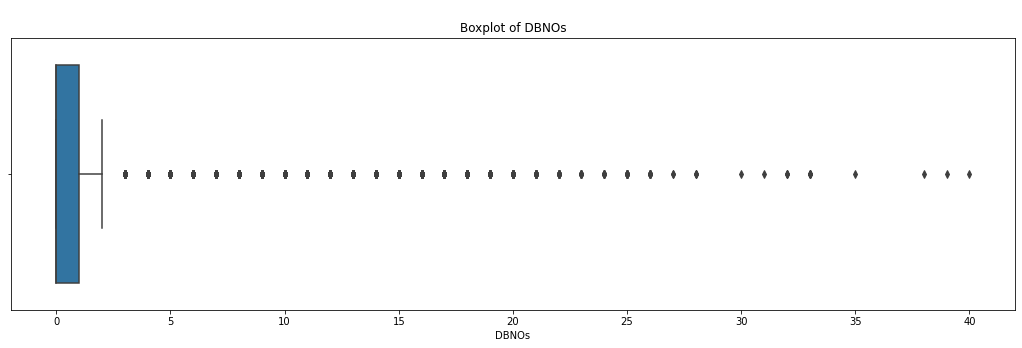

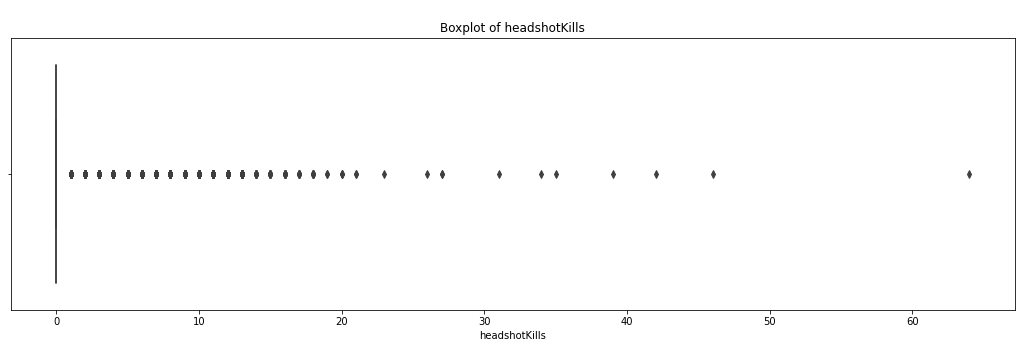

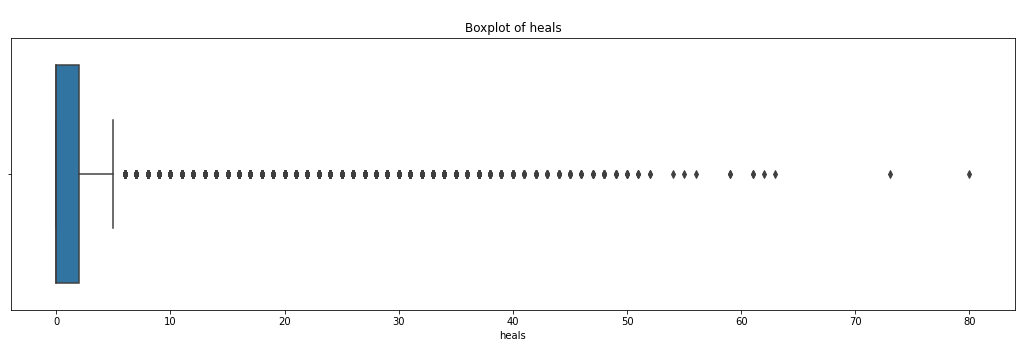

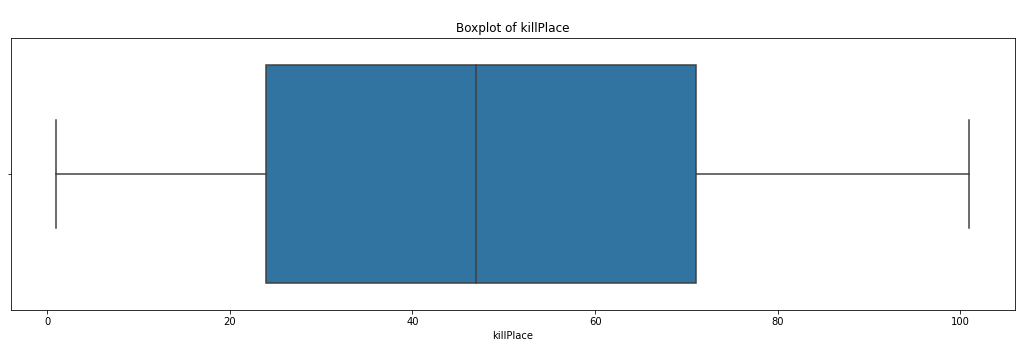

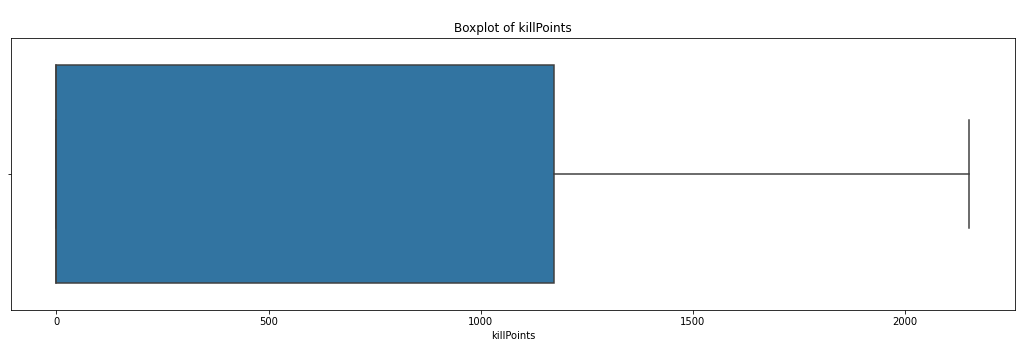

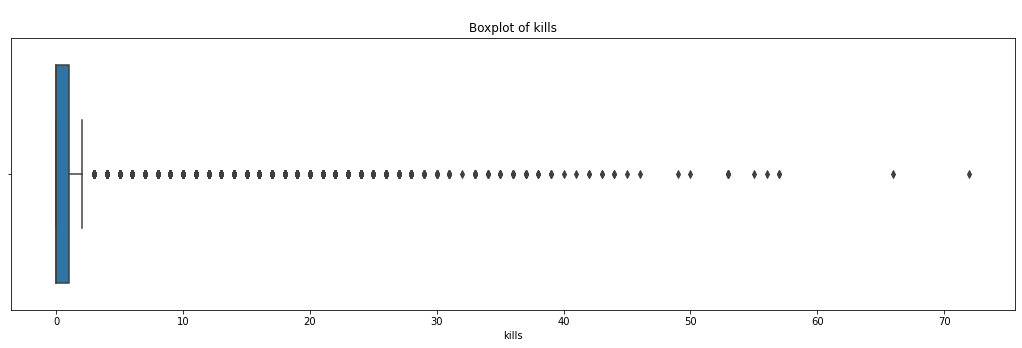

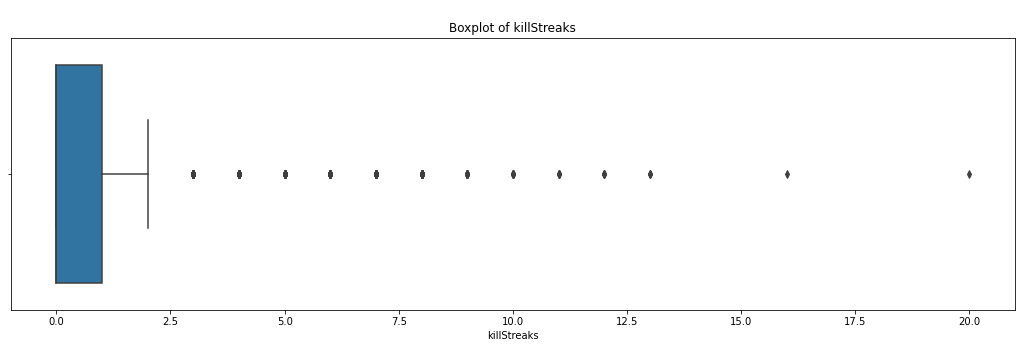

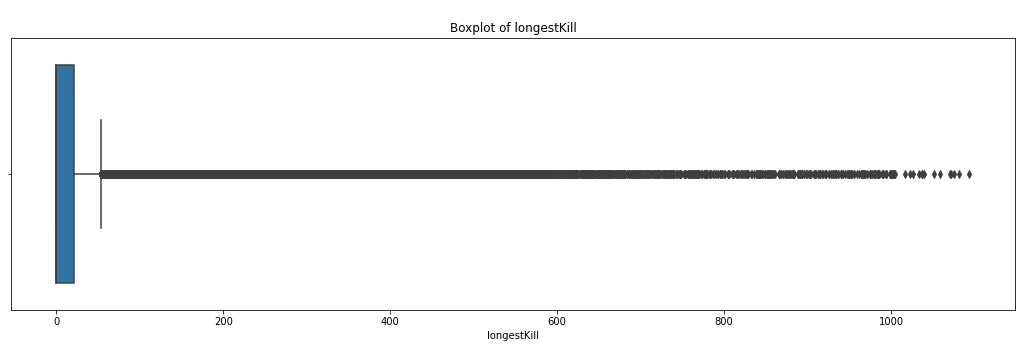

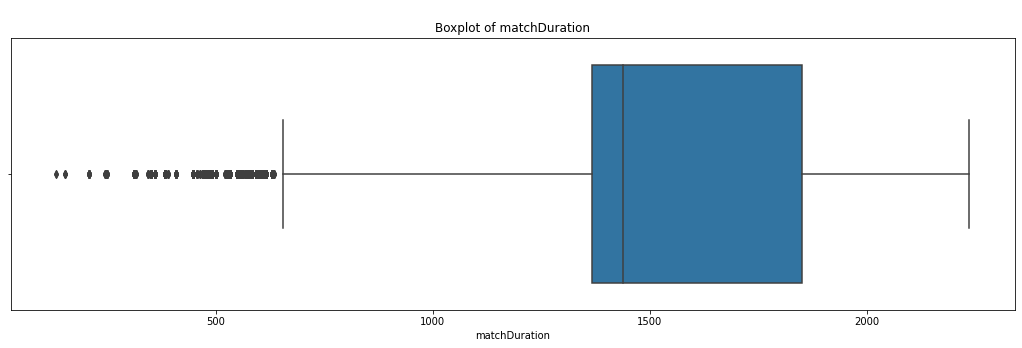

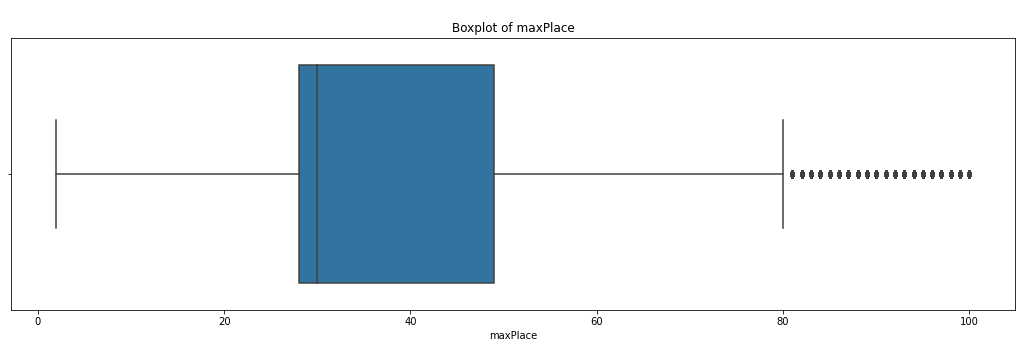

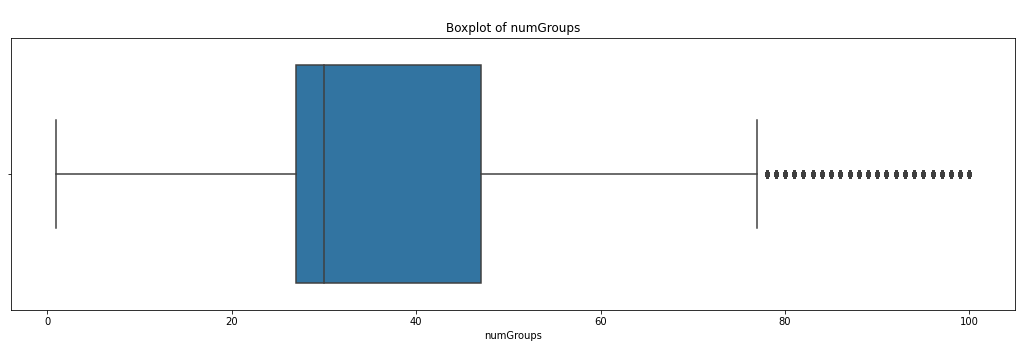

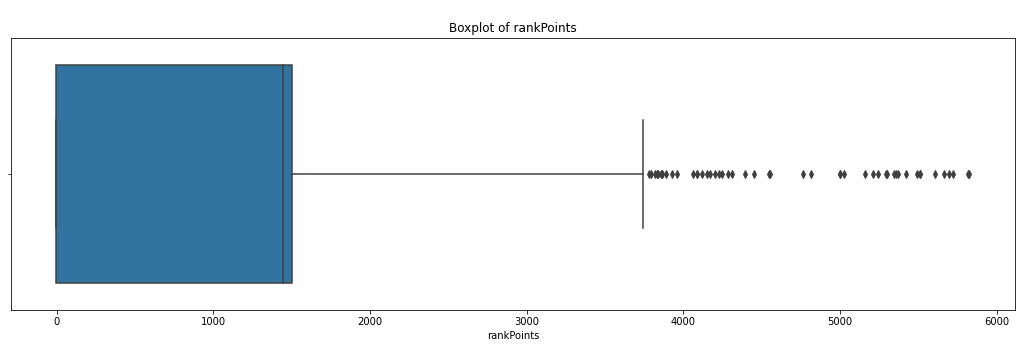

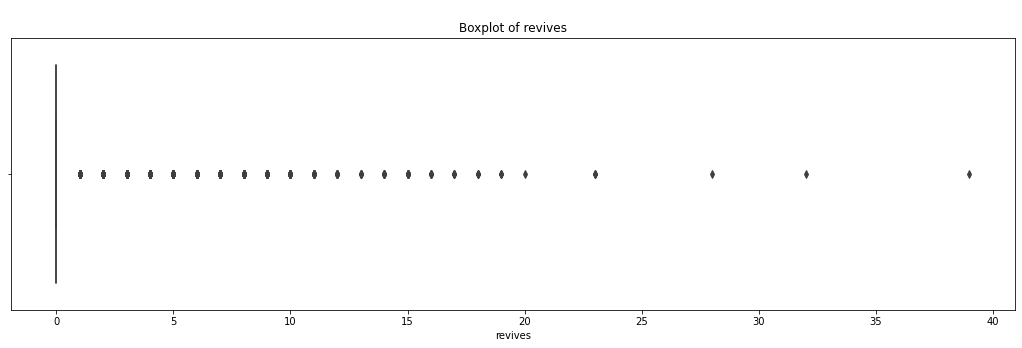

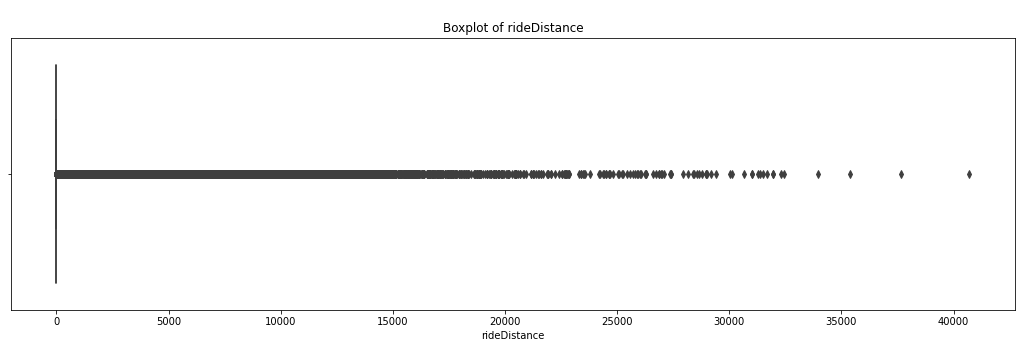

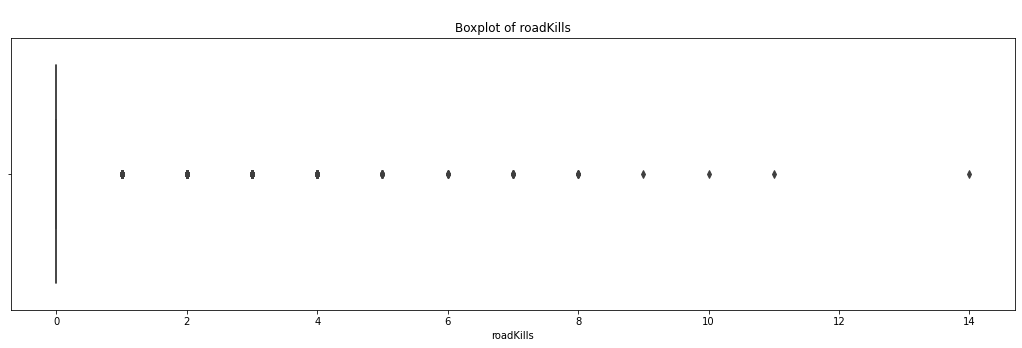

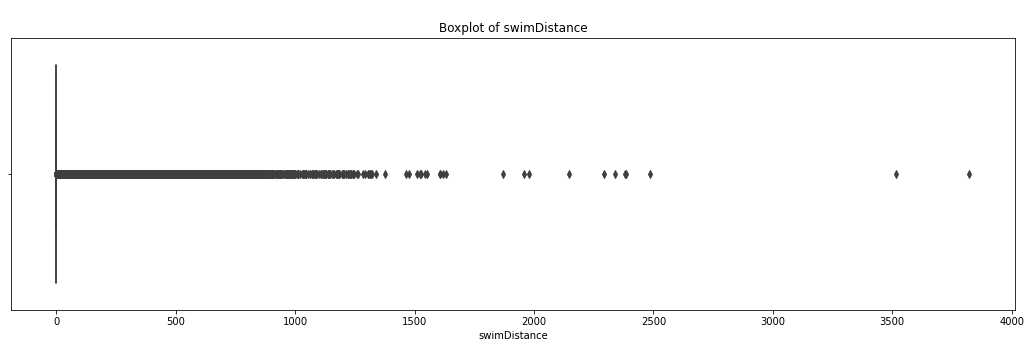

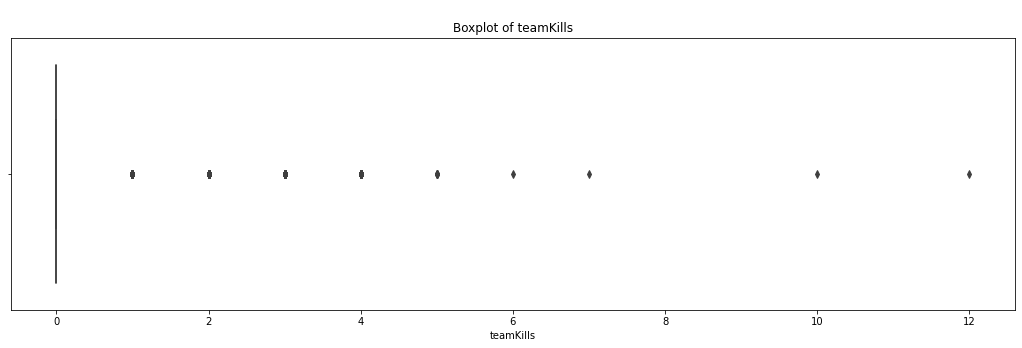

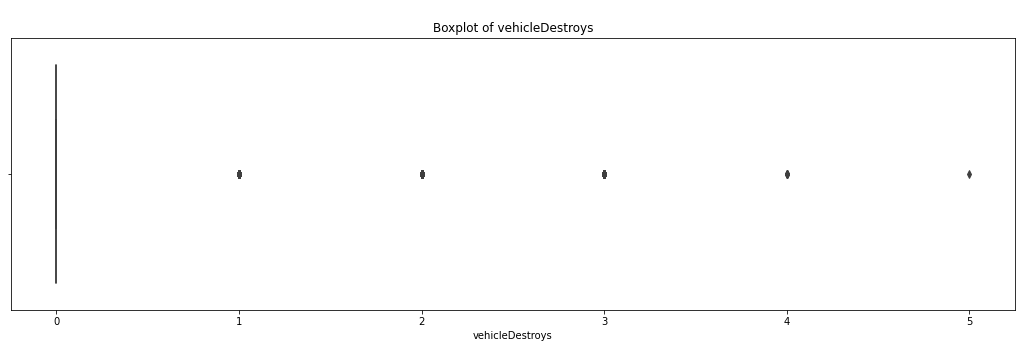

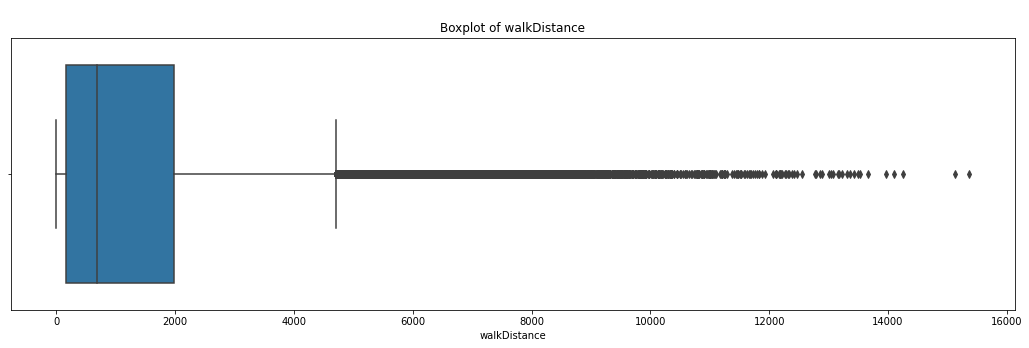

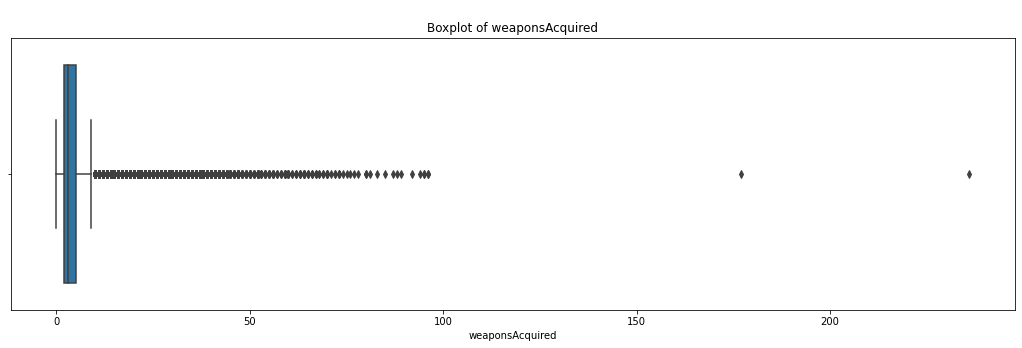

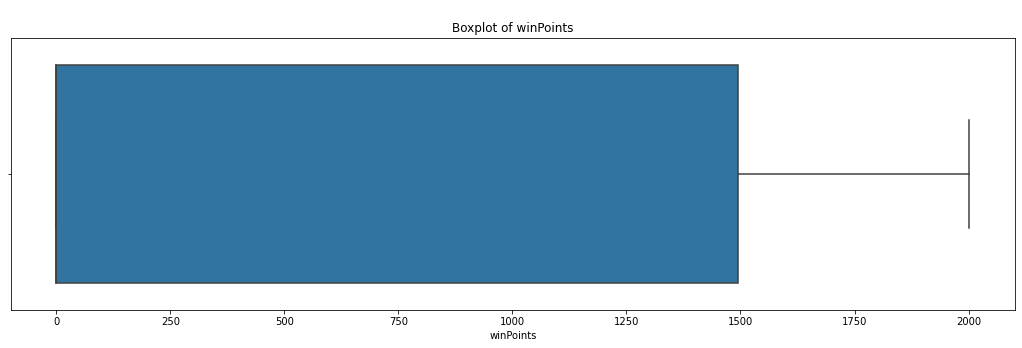

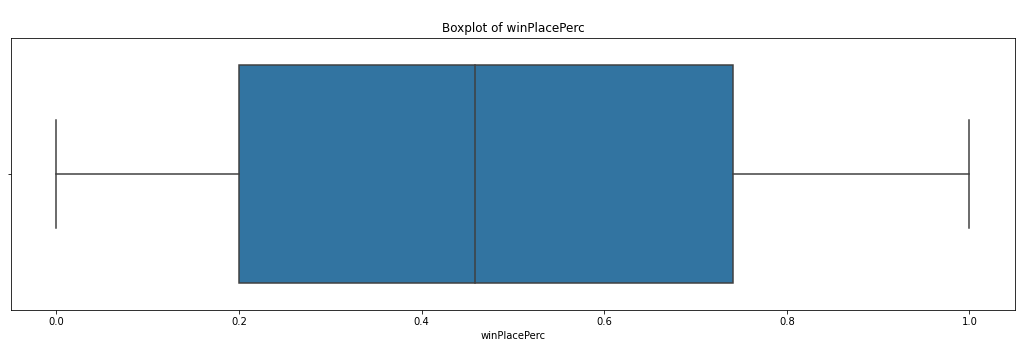

In [ ]:
for i, col in enumerate(df_train_numeric.columns):
    plt.figure(i,figsize=(18,5))
    sns.boxplot(df_train[col])
    plt.title("\nBoxplot of "+ col)
    plt.xlabel(col)
    plt.show()

There are outliers in -
1. assists
2. boosts
3. damageDealt
4. DBNOs
5. headshotKills
6. heals
7. kills
8. killStreaks
9. longestKill
10. matchDuration
11. maxPlace
12. numGroups
13. rankPoints
14. revives
15. rideDistance
16. roadKills
17. swimDistance
18. teamKills
19. vehicleDestroys
20. walkDistance
21. weaponsAcquired

Almost all of the columns contain outliers.

In [ ]:
# Deleting the unnecessary data
del df_train_numeric

In [ ]:
# Invoking Garbage Collector

collected = gc.collect()
print("Garbage collector: collected",
		"%d objects." % collected)

Garbage collector: collected 22868 objects.


#### Kills without movement

##### This is perhaps the most obvious sign of cheating in the game.

##### For Train data

In [ ]:
# New feature totalDistance
df_train['totalDistance'] = df_train['rideDistance'] + df_train['walkDistance'] + df_train['swimDistance']
# New feature killsWithoutMoving
df_train['killsWithoutMoving'] = ((df_train['kills'] > 0) & (df_train['totalDistance'] == 0))

In [ ]:
# Check players who kill without moving
display(df_train[df_train['killsWithoutMoving'] == True].shape)
df_train[df_train['killsWithoutMoving'] == True].head(10)

(1250, 31)

Id         groupId  ... totalDistance  killsWithoutMoving
4119   56843951b43207  c739922f5a1f3f  ...           0.0                True
9683   1e7cd119647e9f  1b246faa71712f  ...           0.0                True
10497  28f55326293682  f3b72eae7751b2  ...           0.0                True
13801  13c9f53a74fee3  0cc67bb1c3bd8f  ...           0.0                True
16611  738051b0a249bc  8b858352735c8f  ...           0.0                True
16930  9497c5afa1eee1  7a2f11d01d79cb  ...           0.0                True
17799  7f82ef01b73dd0  50319d8c3fa08a  ...           0.0                True
19329  9e3dce4c5b9335  47d91121ce2809  ...           0.0                True
23418  feccd5f289ea55  37551ff5e15149  ...           0.0                True
25230  b493bd67d0a888  330ba9e01331f9  ...           0.0                True

[10 rows x 31 columns]

In [ ]:
# Removing the outliers (i.e cheaters)
df_train.drop(df_train[df_train['killsWithoutMoving'] == True].index, inplace=True)
df_train.shape

(3548415, 31)

##### For Test data

In [ ]:
# New feature totalDistance
df_test['totalDistance'] = df_test['rideDistance'] + df_test['walkDistance'] + df_test['swimDistance']
# New feature killsWithoutMoving
df_test['killsWithoutMoving'] = ((df_test['kills'] > 0) & (df_test['totalDistance'] == 0))

In [ ]:
# Check players who kill without moving
display(df_test[df_test['killsWithoutMoving'] == True].shape)
df_test[df_test['killsWithoutMoving'] == True].head(10)

(285, 31)

Id         groupId  ... totalDistance  killsWithoutMoving
186    b19957526f8044  258169d9a82152  ...           0.0                True
3231   cb2ec727ddcc01  2ac23c22ef52ec  ...           0.0                True
13792  269ad03a08574a  3878050038f7ac  ...           0.0                True
15043  7a22cf4d64629f  0bcfe4ab6b2bb8  ...           0.0                True
15510  862192c28c34b1  989d46beb09e00  ...           0.0                True
20672  ac65bb22445e0f  d1b8d47238255f  ...           0.0                True
23155  55bd90408984b5  9b8b1f208d2729  ...           0.0                True
25283  70a0249f50841e  6b903b9a21d3d3  ...           0.0                True
26176  9ed2dd3338e7ca  0715ae41dcdbe1  ...           0.0                True
26327  6333b68eb70006  f7b6eb0d31cbcc  ...           0.0                True

[10 rows x 31 columns]

In [ ]:
# Removing the outliers (i.e cheaters)
df_test.drop(df_test[df_test['killsWithoutMoving'] == True].index, inplace=True)
df_test.shape

(887134, 31)

#### Winning without movement

This is also the most obvious sign of cheating in the game.

In [ ]:
suspects = df_train.query('winPlacePerc ==1 & totalDistance ==0')
display(suspects.shape)
suspects.head()

(629, 31)

Id         groupId  ... totalDistance  killsWithoutMoving
2970   60fc39f213d334  b479a3f434dc8c  ...           0.0               False
20607  1df9826105b2ba  7700641178014d  ...           0.0               False
31258  051b1bf8ffc916  3674271b1de973  ...           0.0               False
33450  987910bfde1dee  6d5396c1c0b4f4  ...           0.0               False
40960  8dd158d915781b  cbfea56f0c9a38  ...           0.0               False

[5 rows x 31 columns]

In [ ]:
# New feature winWithoutMoving
df_train['winWithoutMoving'] = ((df_train['winPlacePerc'] == 1) & (df_train['totalDistance'] == 0))
display(df_train.shape)
df_train.head()

(3548415, 32)

Id         groupId  ... killsWithoutMoving  winWithoutMoving
0  dd1abf8c8dea06  874c02ce3e8883  ...              False             False
1  fc609144bd1681  d64fdc706a385e  ...              False             False
2  4162f2e84a85fd  4ca0a106852af3  ...              False             False
3  77f9aefafd79b7  2a80a0320990bc  ...              False             False
4  5eacc6e736d0b3  17b1572f2599d5  ...              False             False

[5 rows x 32 columns]

In [ ]:
# Removing the outliers (i.e cheaters)
df_train.drop(df_train[df_train['winWithoutMoving'] == True].index, inplace=True)
df_train.shape

(3547786, 32)

#### Illegal killPlace

In [ ]:
df_train['killPlace'].value_counts()

15     38324
6      38306
9      38270
3      38262
7      38260
       ...  
97     12792
98      7966
99      3570
100     1119
101        1
Name: killPlace, Length: 101, dtype: int64

In [ ]:
df_train.shape

(3547786, 32)

In [ ]:
# Removing the outlier
df_train.drop(df_train[df_train['killPlace'] == 101].index, inplace=True)
df_train.shape

(3547785, 32)

In [ ]:
df_train['killPlace'].value_counts()

15     38324
6      38306
9      38270
3      38262
7      38260
       ...  
96     17736
97     12792
98      7966
99      3570
100     1119
Name: killPlace, Length: 100, dtype: int64

In [ ]:
# Deleting the unnecessary data
del suspects

In [ ]:
# Invoking Garbage Collector

collected = gc.collect()
print("Garbage collector: collected",
		"%d objects." % collected)

Garbage collector: collected 150 objects.


### Lineplot for comparision of columns with the Target Variable

#### winPlacePerc v/s assists (i.e Percentile winning placement v/s Number of enemy players this player damaged that were killed by teammates)

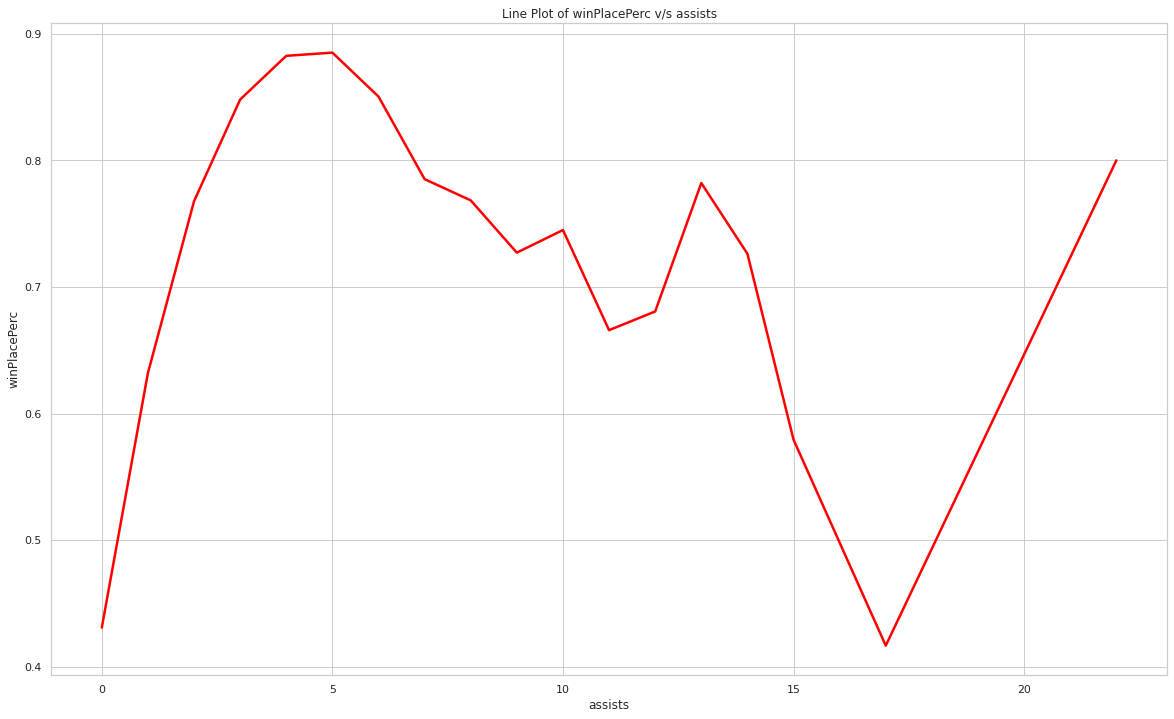

In [ ]:
plt.figure(figsize=(20,12))
sns.set(style='whitegrid')
ax = sns.lineplot(x='assists',y='winPlacePerc', color='red', linewidth=2.5, ci = None, data=df_train)
plt.title('Line Plot of winPlacePerc v/s assists')
plt.show()

It is found from the graph above that, the wining percentage (winPlacePerc) is maximum at 4 to 6 assists and is minimum around 17 assists.

#### winPlacePerc v/s boosts (i.e Percentile winning placement v/s Number of boost items used)

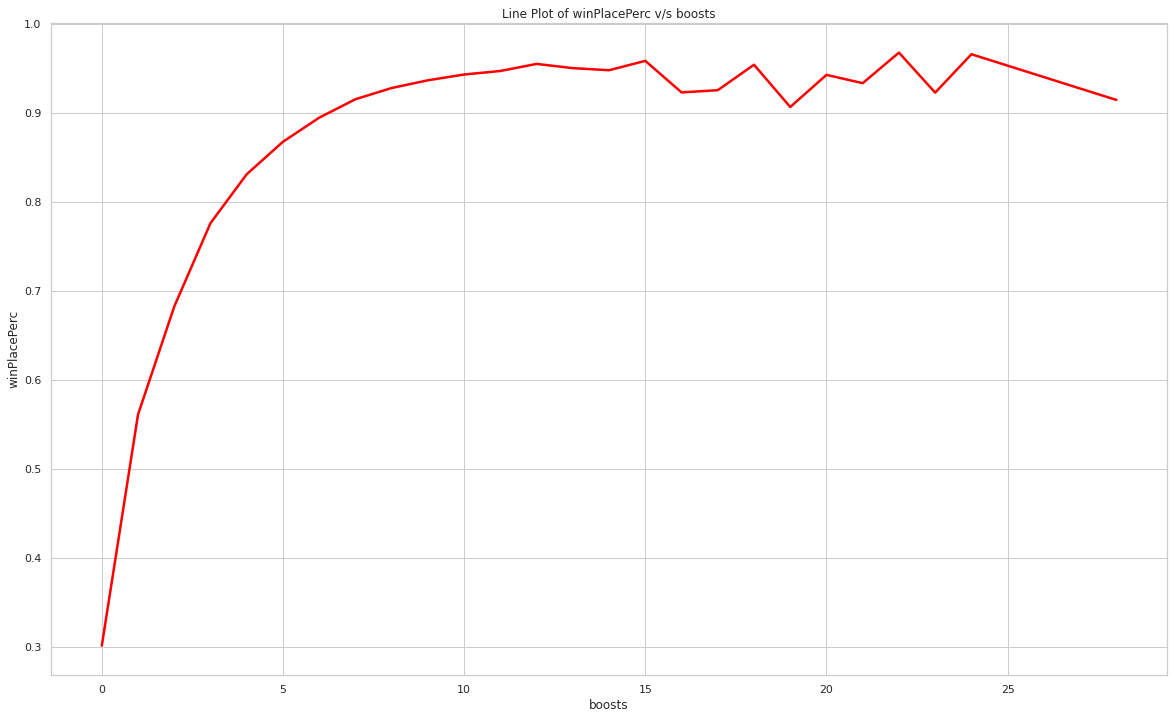

In [ ]:
plt.figure(figsize=(20,12))
sns.set(style='whitegrid')
ax = sns.lineplot(x='boosts',y='winPlacePerc', color='red', linewidth=2.5, ci = None, data=df_train)
plt.title('Line Plot of winPlacePerc v/s boosts')
plt.show()

It is found from the graph above that, the wining percentage (winPlacePerc) is maximum from 10 to 15 boosts and also from 22 to 23 boosts and is minimum at 0 boosts.

#### winPlacePerc v/s damageDealt (i.e Percentile winning placement v/s Total damage dealt)

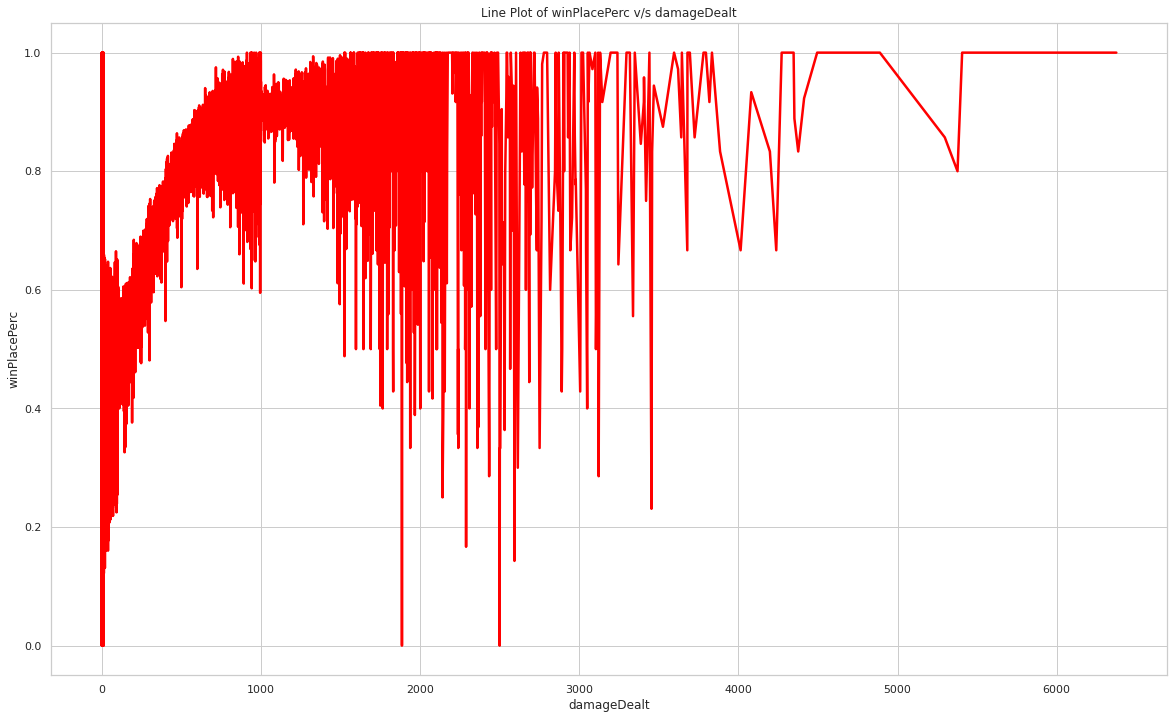

In [ ]:
plt.figure(figsize=(20,12))
sns.set(style='whitegrid')
ax = sns.lineplot(x='damageDealt',y='winPlacePerc', color='red', linewidth=2.5, ci = None, data=df_train)
plt.title('Line Plot of winPlacePerc v/s damageDealt')
plt.show()

It is found from the graph above that, the wining percentage (winPlacePerc) is maximum from 1500 damage onwards and is minimum at 0 damage.

#### winPlacePerc v/s DBNOs (i.e Percentile winning placement v/s Number of enemy players knocked)

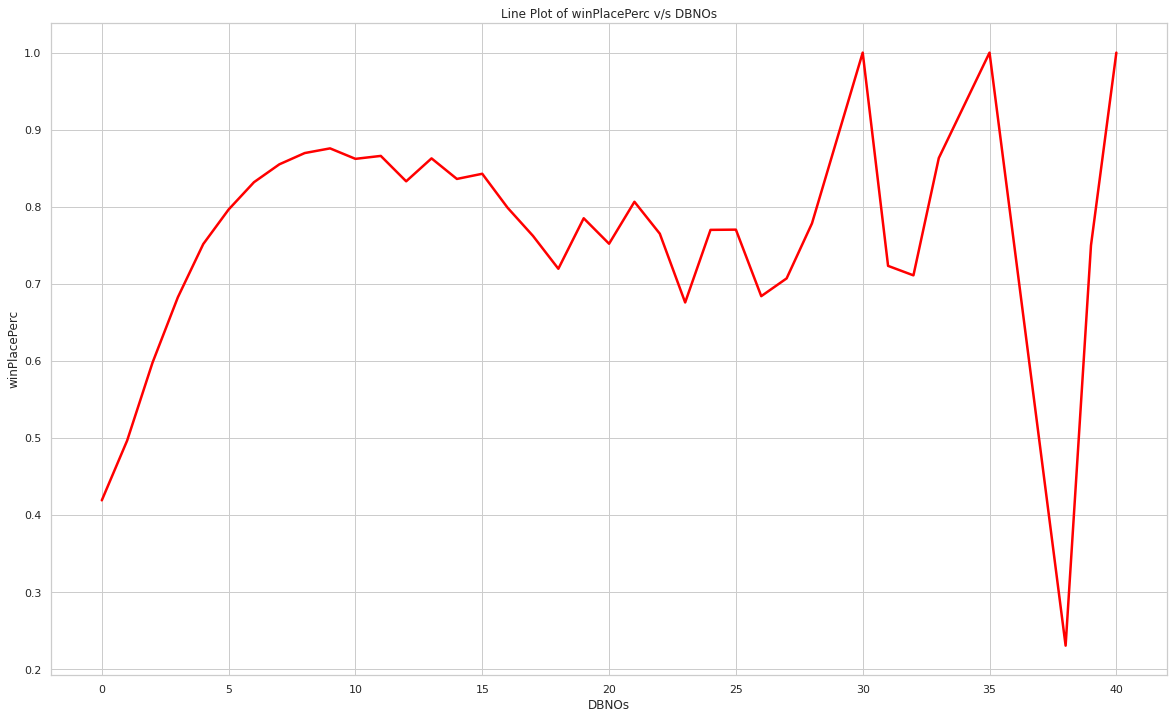

In [ ]:
plt.figure(figsize=(20,12))
sns.set(style='whitegrid')
ax = sns.lineplot(x='DBNOs',y='winPlacePerc', color='red', linewidth=2.5, ci = None, data=df_train)
plt.title('Line Plot of winPlacePerc v/s DBNOs')
plt.show()

It is found from the graph above that, the wining percentage (winPlacePerc) is maximum at 30, 35 and 40 DBNOs and is minimum around 38 DBNOs.

#### winPlacePerc v/s headshotKills (i.e Percentile winning placement v/s Number of enemy players killed with headshots)

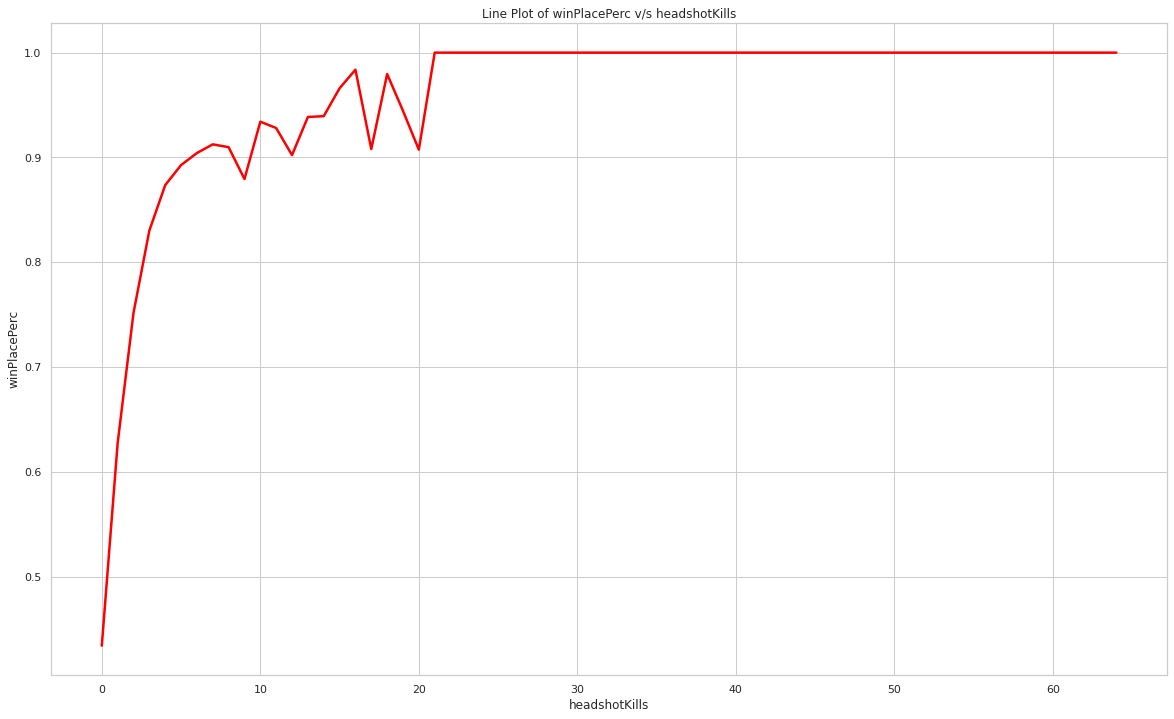

In [ ]:
plt.figure(figsize=(20,12))
sns.set(style='whitegrid')
ax = sns.lineplot(x='headshotKills',y='winPlacePerc', color='red', linewidth=2.5, ci = None, data=df_train)
plt.title('Line Plot of winPlacePerc v/s headshotKills')
plt.show()

It is found from the graph above that, the wining percentage (winPlacePerc) is maximum from 21 headshotKills onwards and is minimum at 0 headshotKills.

#### winPlacePerc v/s heals (i.e Percentile winning placement v/s Number of healing items used)

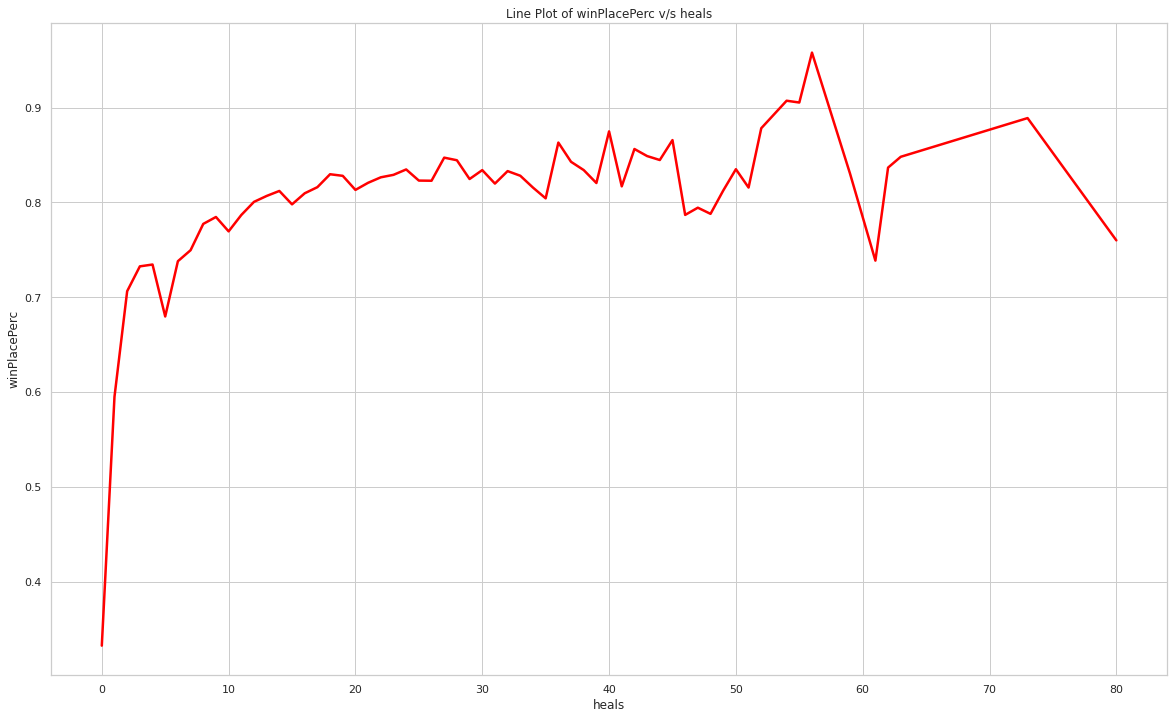

In [ ]:
plt.figure(figsize=(20,12))
sns.set(style='whitegrid')
ax = sns.lineplot(x='heals',y='winPlacePerc', color='red', linewidth=2.5, ci = None, data=df_train)
plt.title('Line Plot of winPlacePerc v/s heals')
plt.show()

It is found from the graph above that, the wining percentage (winPlacePerc) is maximum around 57 heals and minimum at 0 heals.

#### winPlacePerc v/s killPlace (i.e Percentile winning placement v/s Ranking in match of number of enemy players killed)

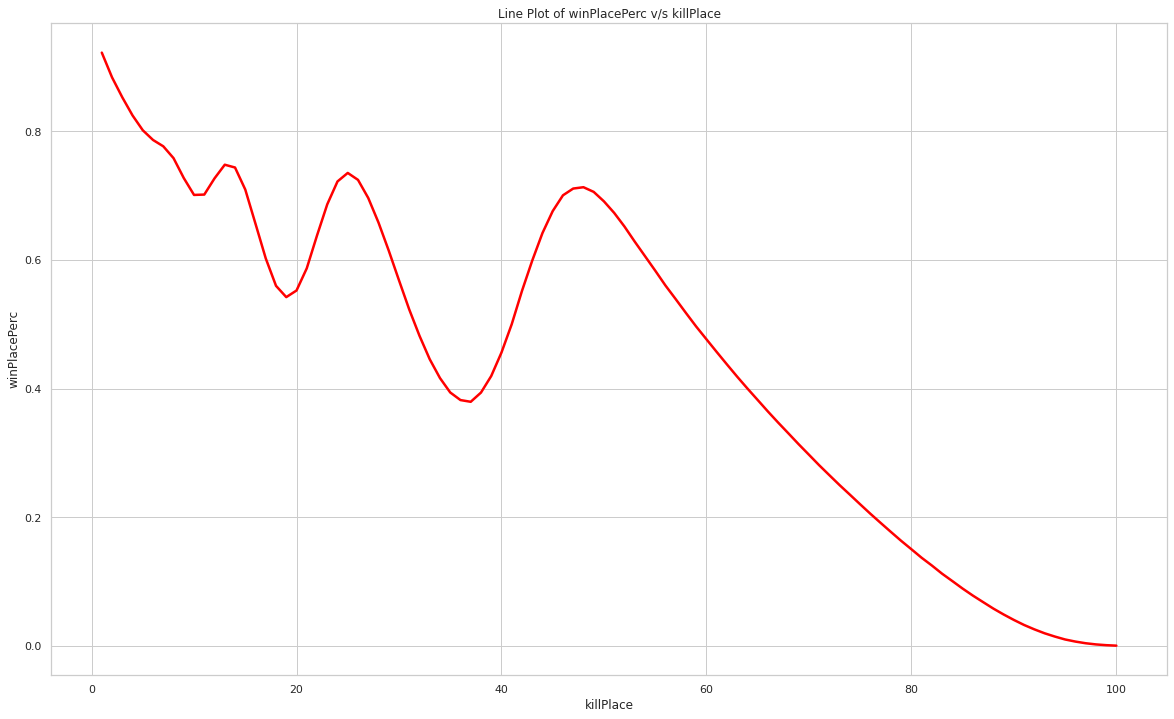

In [ ]:
plt.figure(figsize=(20,12))
sns.set(style='whitegrid')
ax = sns.lineplot(x='killPlace',y='winPlacePerc', color='red', linewidth=2.5, ci = None, data=df_train)
plt.title('Line Plot of winPlacePerc v/s killPlace')
plt.show()

It is found from the graph above that, the wining percentage (winPlacePerc) is maximum at killPlace 1 and is minimum at killPlace 100.

#### winPlacePerc v/s kills (i.e Percentile winning placement v/s Number of enemy players killed)

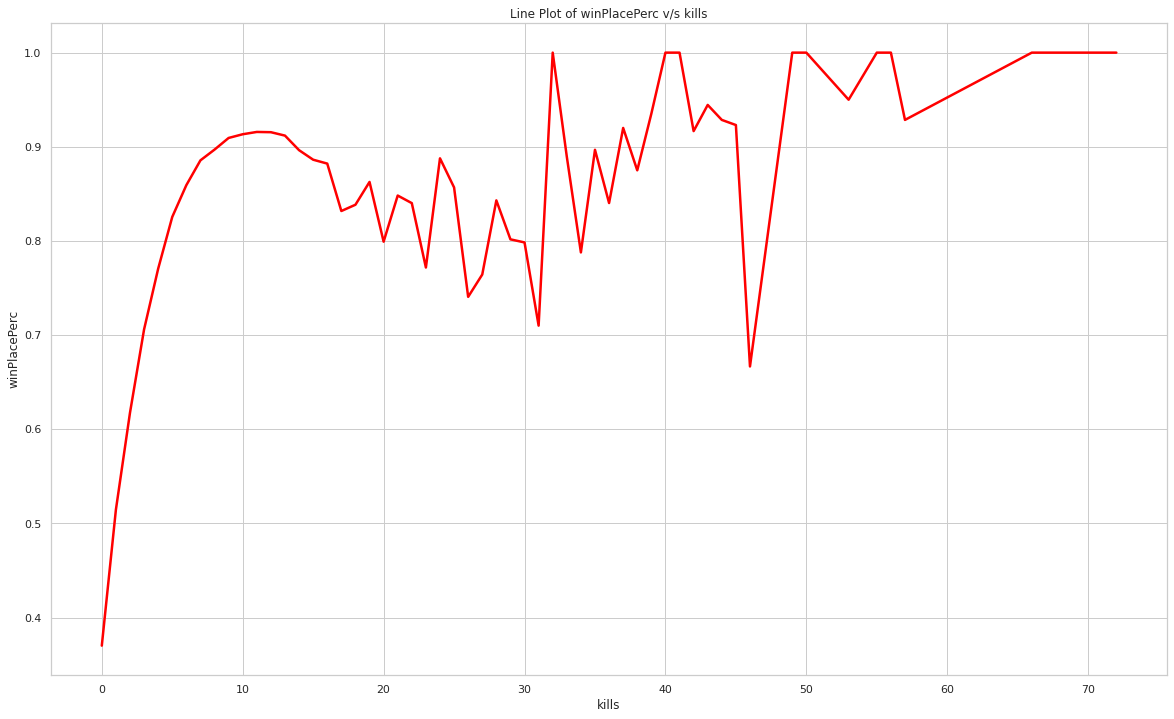

In [ ]:
plt.figure(figsize=(20,12))
sns.set(style='whitegrid')
ax = sns.lineplot(x='kills',y='winPlacePerc', color='red', linewidth=2.5, ci = None, data=df_train)
plt.title('Line Plot of winPlacePerc v/s kills')
plt.show()

It is found from the graph above that, the wining percentage (winPlacePerc) is maximum around 32, 40, 50, 57 and 67 kills and is minimum at 0 kills.

#### winPlacePerc v/s killStreaks (i.e Percentile winning placement v/s Max number of enemy players killed in a short amount of time)

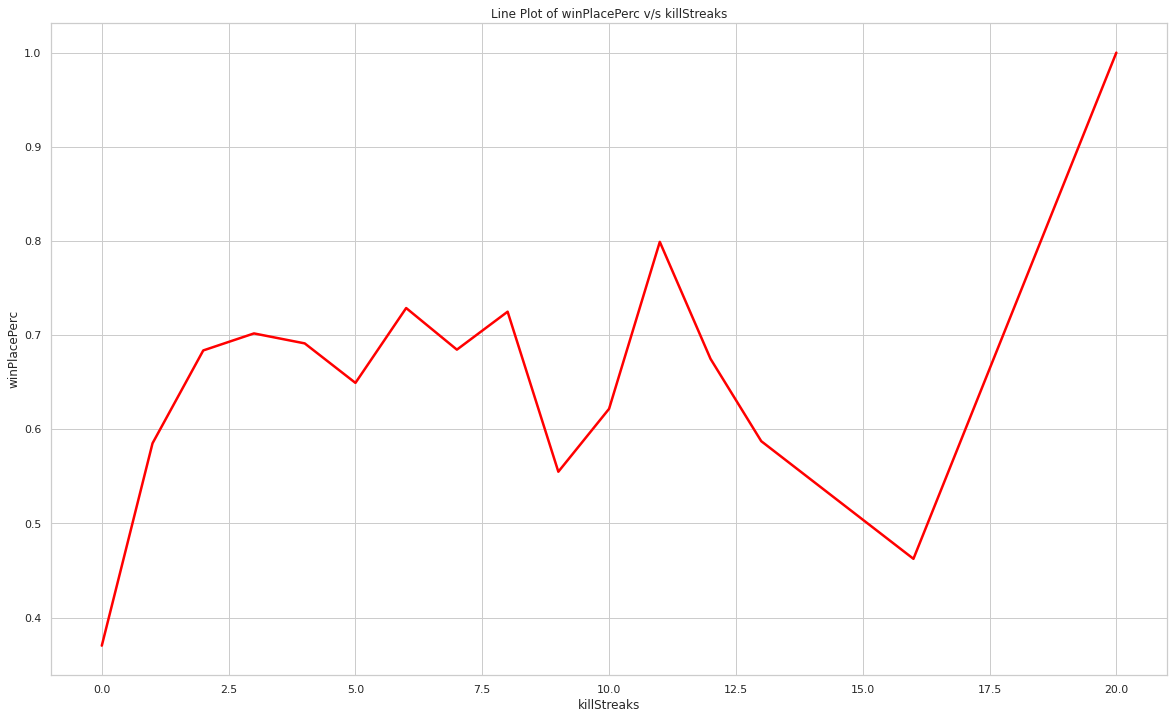

In [ ]:
plt.figure(figsize=(20,12))
sns.set(style='whitegrid')
ax = sns.lineplot(x='killStreaks',y='winPlacePerc', color='red', linewidth=2.5, ci = None, data=df_train)
plt.title('Line Plot of winPlacePerc v/s killStreaks')
plt.show()

It is found from the graph above that, the wining percentage (winPlacePerc) is maximum at 20 killStreaks and is minimum at 0 killStreaks.

#### winPlacePerc v/s revives (i.e Percentile winning placement v/s Number of times this player revived teammates)

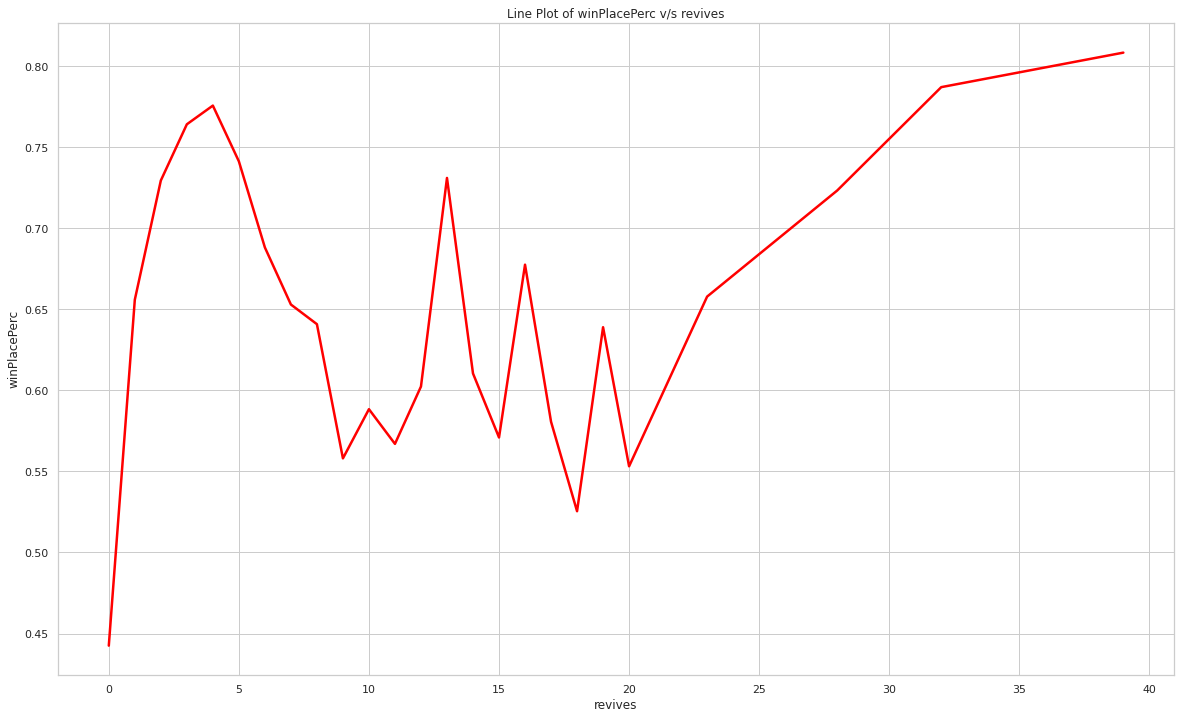

In [ ]:
plt.figure(figsize=(20,12))
sns.set(style='whitegrid')
ax = sns.lineplot(x='revives',y='winPlacePerc', color='red', linewidth=2.5, ci = None, data=df_train)
plt.title('Line Plot of winPlacePerc v/s revives')
plt.show()

It is found from the graph above that, the wining percentage (winPlacePerc) is maximum from 35 revives onwards and is minimum at 0 revives.

#### winPlacePerc v/s roadKills (i.e Percentile winning placement v/s Number of kills while in a vehicle)

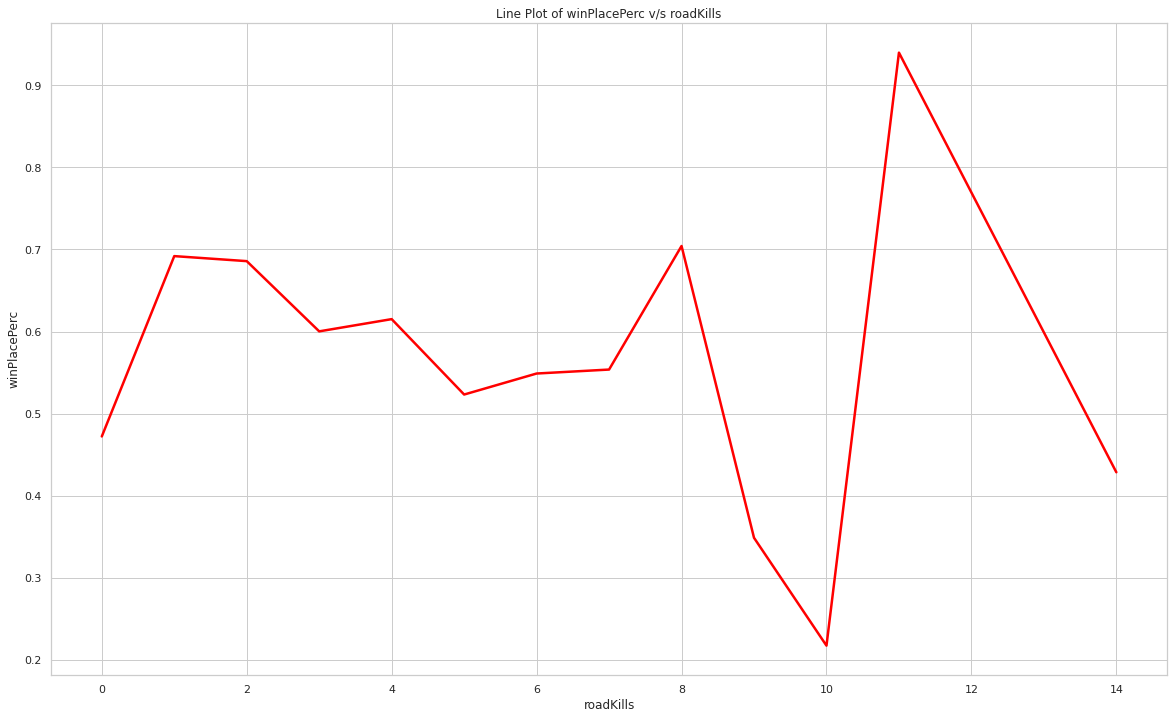

In [ ]:
plt.figure(figsize=(20,12))
sns.set(style='whitegrid')
ax = sns.lineplot(x='roadKills',y='winPlacePerc', color='red', linewidth=2.5, ci = None, data=df_train)
plt.title('Line Plot of winPlacePerc v/s roadKills')
plt.show()

It is found from the graph above that, the wining percentage (winPlacePerc) is maximum around 11 roadKills and is minimum at 10 roadKills.

#### winPlacePerc v/s swimDistance (i.e Percentile winning placement v/s Total distance traveled by swimming measured in meters)

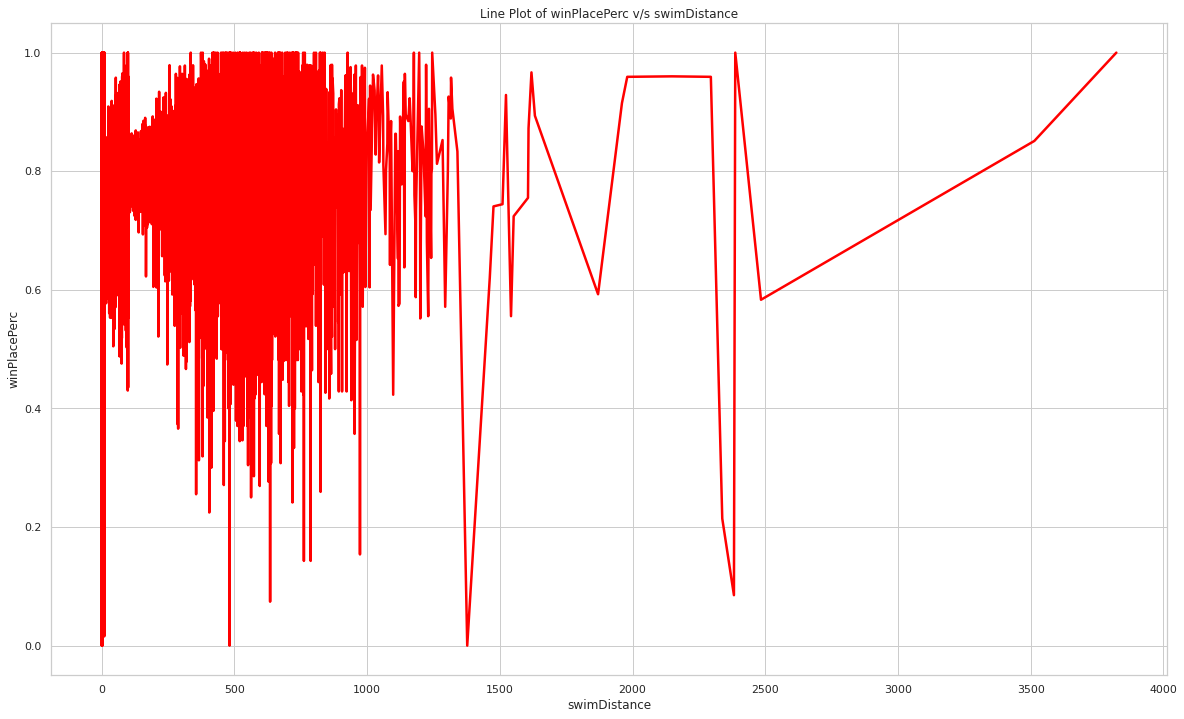

In [ ]:
plt.figure(figsize=(20,12))
sns.set(style='whitegrid')
ax = sns.lineplot(x='swimDistance',y='winPlacePerc', color='red', linewidth=2.5, ci = None, data=df_train)
plt.title('Line Plot of winPlacePerc v/s swimDistance')
plt.show()

It is found from the graph above that, the wining percentage (winPlacePerc) is maximum in the range 0 to 1000 meters and is minimum at 0, 500 and around 1400 meters.

#### winPlacePerc v/s rideDistance (i.e Percentile winning placement v/s Total distance traveled in vehicles measured in meters)

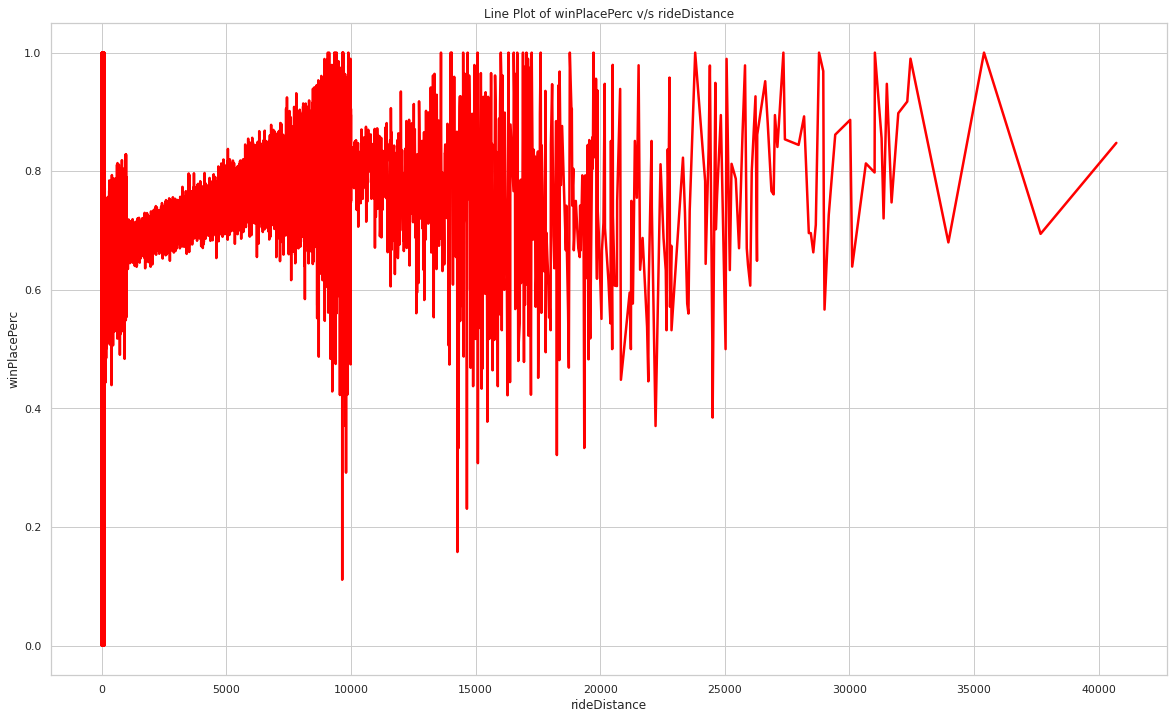

In [ ]:
plt.figure(figsize=(20,12))
sns.set(style='whitegrid')
ax = sns.lineplot(x='rideDistance',y='winPlacePerc', color='red', linewidth=2.5, ci = None, data=df_train)
plt.title('Line Plot of winPlacePerc v/s rideDistance')
plt.show()

It is found from the graph above that, the wining percentage (winPlacePerc) is maximum at 0, 10000, and from range 15000 to 35000 meters and is minimum at 0 meters.

#### winPlacePerc v/s walkDistance (i.e Percentile winning placement v/s Total distance traveled on foot measured in meters)

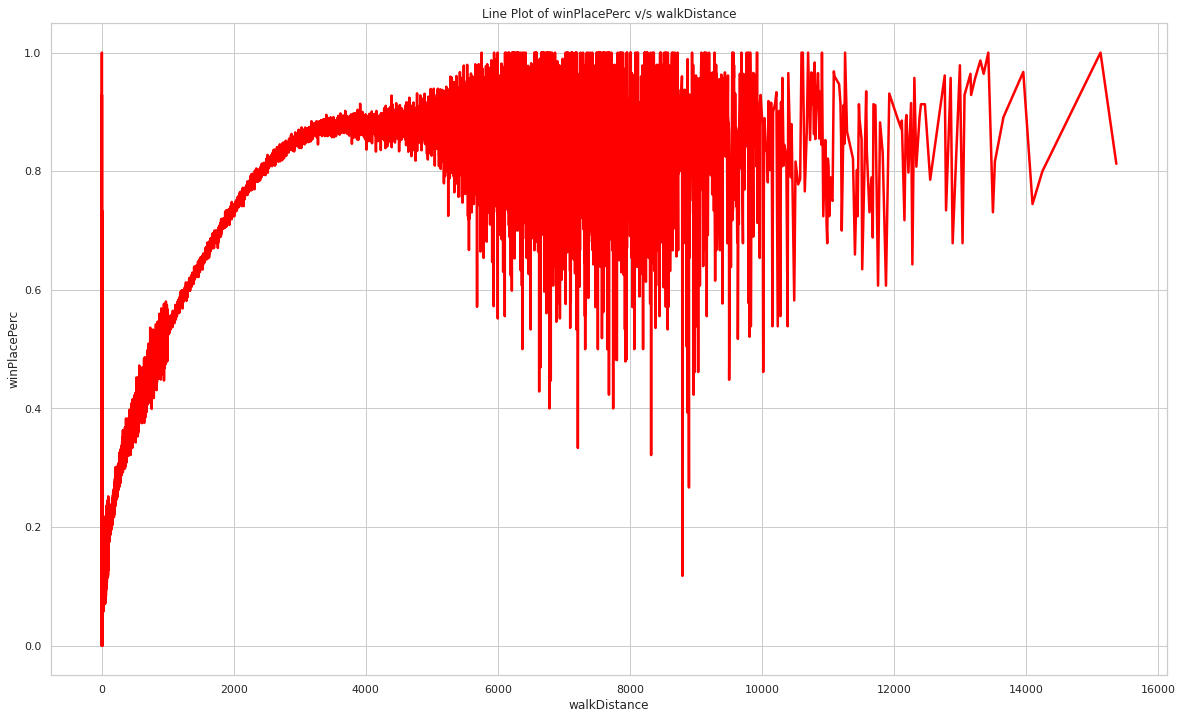

In [ ]:
plt.figure(figsize=(20,12))
sns.set(style='whitegrid')
ax = sns.lineplot(x='walkDistance',y='winPlacePerc', color='red', linewidth=2.5, ci = None, data=df_train)
plt.title('Line Plot of winPlacePerc v/s walkDistance')
plt.show()

It is found from the graph above that, the wining percentage (winPlacePerc) is maximum at 0, and in range from 6000 to 11000 meters and is minimum at 0 meters.

In [ ]:
# Invoking Garbage Collector

collected = gc.collect()
print("Garbage collector: collected",
		"%d objects." % collected)

Garbage collector: collected 37678 objects.


## Encoding Categorical Feature matchType

In [ ]:
 df_train = pd.get_dummies(df_train, columns=["matchType"], prefix=["Type"])
 df_train

Id         groupId  ... Type_squad  Type_squad-fpp
0        dd1abf8c8dea06  874c02ce3e8883  ...          0               0
1        fc609144bd1681  d64fdc706a385e  ...          1               0
2        4162f2e84a85fd  4ca0a106852af3  ...          0               1
3        77f9aefafd79b7  2a80a0320990bc  ...          0               1
4        5eacc6e736d0b3  17b1572f2599d5  ...          0               1
...                 ...             ...  ...        ...             ...
3557567  0c24dab84b73fe  56c3c5e4343759  ...          0               0
3557568  131e18b3075887  56f799406194b7  ...          0               1
3557569  a30fb1145d8266  8d8377f3024d8a  ...          0               1
3557570  6d7a831bb651f2  346ea3d561c44e  ...          0               0
3557571  35b0776ae958d8  c08650bf69fd8e  ...          0               1

[3547785 rows x 43 columns]

In [ ]:
 df_test = pd.get_dummies(df_test, columns=["matchType"], prefix=["Type"])
 df_test

Id         groupId  ... Type_squad  Type_squad-fpp
0       3819823802f48a  f0fd309f8ca457  ...          0               1
1       aa439f81e8792b  c83cc7dcb364cd  ...          1               0
2       5284c4d2d9183c  7bfd6bd25707fd  ...          0               0
3       c15709d34368e3  4e6a9999406061  ...          0               1
4       d749a74a11eb0a  f2a554bfed0c58  ...          0               1
...                ...             ...  ...        ...             ...
889389  8758ccc2119cb4  4676bae6e20eaf  ...          0               1
889390  12f94992da4dc7  907492739ae47e  ...          0               0
889391  5c59fceda16050  3affb4c10c60e6  ...          0               1
889392  c38b7f76467a12  ab0ef1b21c2c19  ...          0               1
889393  0d2349d0978e99  ceecd33f4d5ed0  ...          0               1

[887134 rows x 42 columns]

## Feature Selection

We are going to select the attributes w.r.t their correlation with the target variable (i.e winPlacePerc)

Selection Criteria -

For Negative Correlation - Correlation with the target should be less than -0.25.

For Positive Correlation - Correlation with the target should be greater than 0.25.

Here we are ignoring the attributes who have No Correlation with the target (i.e Between -0.25 to 0.25).

In [ ]:
df_corr_win[df_corr_win['Correlation_with_winPlacePerc'] > 0.25].Correlation_with_winPlacePerc

assists            0.299663
boosts             0.634140
damageDealt        0.440836
DBNOs              0.279796
headshotKills      0.277775
heals              0.427908
kills              0.420087
killStreaks        0.377551
longestKill        0.410180
rideDistance       0.342800
walkDistance       0.810840
weaponsAcquired    0.584204
winPlacePerc       1.000000
Name: Correlation_with_winPlacePerc, dtype: float64

We can see that there are 12 positively correlated attributes with the target which satisfy the condition.

They are -
1. assists
2. boosts
3. damageDealt
4. DBNOs
5. headshotKills
6. heals
7. kills
8. killStreaks
9. longestKill
10. rideDistance
11. walkDistance
12. weaponsAcquired

In [ ]:
df_corr_win[df_corr_win['Correlation_with_winPlacePerc'] < -0.25].Correlation_with_winPlacePerc

killPlace   -0.719063
Name: Correlation_with_winPlacePerc, dtype: float64

We can see that there is only 1 negatively correlated attribute with the target which satisfy the condition.

The attribute is - killPlace

So, we select 13 features which are correlated with the target.

List of all selected features (correlated and encoded) -

In [ ]:
selected_features = ['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace',
                     'kills', 'killStreaks', 'longestKill',
                     'rideDistance', 'walkDistance', 'weaponsAcquired', 'Type_duo', 'Type_duo-fpp', 'Type_normal-duo',
       'Type_normal-duo-fpp', 'Type_normal-solo', 'Type_normal-solo-fpp',
       'Type_normal-squad', 'Type_normal-squad-fpp', 'Type_solo',
       'Type_solo-fpp', 'Type_squad', 'Type_squad-fpp']
selected_features

['assists',
 'boosts',
 'damageDealt',
 'DBNOs',
 'headshotKills',
 'heals',
 'killPlace',
 'kills',
 'killStreaks',
 'longestKill',
 'rideDistance',
 'walkDistance',
 'weaponsAcquired',
 'Type_duo',
 'Type_duo-fpp',
 'Type_normal-duo',
 'Type_normal-duo-fpp',
 'Type_normal-solo',
 'Type_normal-solo-fpp',
 'Type_normal-squad',
 'Type_normal-squad-fpp',
 'Type_solo',
 'Type_solo-fpp',
 'Type_squad',
 'Type_squad-fpp']

## Splitting selected X (Train,Test) and Y (Train,Test) variables for Multiple Regression

### For X (Train,Test)

In [ ]:
X_train = df_train[selected_features]
X_train

assists  boosts  ...  Type_squad  Type_squad-fpp
0              0       0  ...           0               0
1              0       0  ...           1               0
2              0       2  ...           0               1
3              0       1  ...           0               1
4              1       9  ...           0               1
...          ...     ...  ...         ...             ...
3557567        0       1  ...           0               0
3557568        0       3  ...           0               1
3557569        1       1  ...           0               1
3557570        0       3  ...           0               0
3557571        1       3  ...           0               1

[3547785 rows x 25 columns]

In [ ]:
X_test = df_test[selected_features]
X_test

assists  boosts  damageDealt  ...  Type_solo-fpp  Type_squad  Type_squad-fpp
0             0       3        48.12  ...              0           0               1
1             3       8       954.70  ...              0           1               0
2             0       0       249.80  ...              0           0               0
3             0       0       100.00  ...              0           0               1
4             0       0        10.00  ...              0           0               1
...         ...     ...          ...  ...            ...         ...             ...
889389        0       1        32.34  ...              0           0               1
889390        0       7       604.50  ...              1           0               0
889391        0       1       100.00  ...              0           0               1
889392        1       0        71.05  ...              0           0               1
889393        0       3       288.10  ...              0           0               1

[887134 rows x 25 columns]

### For Y (Train,Test)

In [ ]:
y_train = df_train['winPlacePerc']
y_train

0          0.0612
1          0.0769
2          0.8276
3          0.7857
4          0.8519
            ...  
3557567    0.6739
3557568    0.7778
3557569    0.8519
3557570    0.7826
3557571    0.7143
Name: winPlacePerc, Length: 3547785, dtype: float64

In [ ]:
y_test = df_test['winPlacePerc']
y_test

0         0.6522
1         0.9032
2         0.2766
3         0.2963
4         0.5714
           ...  
889389    0.5556
889390    0.9778
889391    0.3929
889392    0.2692
889393    0.9200
Name: winPlacePerc, Length: 887134, dtype: float64

In [ ]:
# Deleting the unnecessary data
del df_corr_win
del df_train
del Train

In [ ]:
# Invoking Garbage Collector

collected = gc.collect()
print("Garbage collector: collected",
		"%d objects." % collected)

Garbage collector: collected 274 objects.


## Normalizing the Data

In [ ]:
scaler = preprocessing.MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_train_normalized

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.07142857, 0.0035451 , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.04545455, 0.03571429, 0.00518588, ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.10714286, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04545455, 0.10714286, 0.01393569, ..., 0.        , 0.        ,
        1.        ]])

In [ ]:
X_test_normalized = scaler.transform(X_test)
X_test_normalized

array([[0.        , 0.10714286, 0.00754824, ..., 0.        , 0.        ,
        1.        ],
       [0.13636364, 0.28571429, 0.14975686, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.03918431, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.03571429, 0.01568627, ..., 0.        , 0.        ,
        1.        ],
       [0.04545455, 0.        , 0.0111451 , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.10714286, 0.04519216, ..., 0.        , 0.        ,
        1.        ]])

In [ ]:
# Invoking Garbage Collector

collected = gc.collect()
print("Garbage collector: collected",
		"%d objects." % collected)

Garbage collector: collected 150 objects.


## Multiple Regression

### Using LinearRegression() from sklearn.linear_model

#### Fitting the model with X and y train values

In [ ]:
regr = linear_model.LinearRegression()
regr.fit(X_train_normalized, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### Predicting the y values with X test values

In [ ]:
y_pred = regr.predict(X_test_normalized)
y_pred

array([0.77178955, 0.75894165, 0.34307861, ..., 0.41488647, 0.27606201,
       0.68569946])

#### Regression coefficients

In [ ]:
regr.coef_

array([ 4.25853617e-01,  4.73080922e-01,  3.20034040e-01, -3.56885180e-01,
        8.99041140e-02,  2.89215637e-02, -7.21126828e-01, -6.64184700e-01,
       -2.79511793e+00, -2.67249762e-02,  3.34244674e-01,  1.69035908e+00,
        2.60690275e+00,  2.29237276e+11,  2.29237276e+11,  2.29237276e+11,
        2.29237276e+11,  2.29237276e+11,  2.29237276e+11,  2.29237276e+11,
        2.29237276e+11,  2.29237276e+11,  2.29237276e+11,  2.29237276e+11,
        2.29237276e+11])

#### R squared value (i.e model score)

In [ ]:
print('R squared value of Train data:',regr.score(X_train_normalized, y_train))

R squared value of Train data: 0.8132663629060692


In [ ]:
print('R squared value of Test data:',regr.score(X_test_normalized, y_test))

R squared value of Test data: 0.8128875384797181


#### Mean Squared Error (MSE) and Root Mean Square Error (RMSE)

In [ ]:
print('Mean Squared Error (MSE) :',mean_squared_error(y_test, y_pred))

Mean Squared Error (MSE) : 0.017679661006222692


In [ ]:
print('Root Mean Squared Error (RMSE) :',np.sqrt(mean_squared_error(y_test, y_pred)))

Root Mean Squared Error (RMSE) : 0.1329648863656217


In [ ]:
# Invoking Garbage Collector

collected = gc.collect()
print("Garbage collector: collected",
		"%d objects." % collected)

Garbage collector: collected 250 objects.


### Using statsmodels.api - OLS (Ordinary Least Squares) method

#### Fitting the model with X and y train values

In [ ]:
# An intercept is not included by default and
# should be added using sm.add_constant(X) so that it also fits an intercept.

lr_1 = sm.OLS(y_train, sm.add_constant(X_train_normalized)).fit()
print(lr_1.summary())

                            OLS Regression Results                            
Dep. Variable:           winPlacePerc   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                 6.438e+05
Date:                Fri, 23 Apr 2021   Prob (F-statistic):               0.00
Time:                        12:42:05   Log-Likelihood:             2.1285e+06
No. Observations:             3547785   AIC:                        -4.257e+06
Df Residuals:                 3547760   BIC:                        -4.257e+06
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5517      0.001    411.301      0.0

Interpretation of the summary table -

1. **Df Residuals** - This is another name for our Degrees of Freedom in our mode. This is calculated in the form of 'n-k-1' or 'number of observations-number of predicting variables-1'.

2. **Df Model** - This numbers our predicting variables.

3. **Covariance** - It is a measure of how two variables are linked in a positive or negative manner, and a robust covariance is one that is calculated in a way to minimize or eliminate variables, which is not the case here. Our Covariance Type is listed as nonrobust.

4. **R-squared** - It signifies the 'percentage variation in dependent that is explained by independent variables'. Here, 81.3% variation in y is explained by X1, X2,......, X25.

5. **Adj. R-squared** - This is the modified version of R-squared which is adjusted for the number of variables in the regression. It increases only when an additional variable adds to the explanatory power to the regression. Here we are getting the Adj. R-squared value same as R-squared value.

6. **Prob(F-Statistic)** - This tells the overall significance of the regression. This is to assess the significance level of all the variables together unlike the t-statistic that measures it for individual variables. The null hypothesis under this is 'all the regression coefficients are equal to zero'. Prob(F-statistics) depicts the probability of null hypothesis being true. As per the above results, probability is close to zero. This implies that overall the regressions is meaningful.

7. **coef** - It is the coefficient. For our intercept, it is the value of the intercept. For each variable, it is the measurement of how change in that variable affects the independent variable. It is the ‘m’ in ‘y = mx + b’ One unit of change in the dependent variable will affect the variable’s coefficient’s worth of change in the independent variable. If the coefficient is negative, they have an inverse relationship. As one rises, the other falls.

8. **std err** - It is an estimate of the standard deviation of the coefficient, a measurement of the amount of variation in the coefficient throughout its data points.

9. **t** - The t is related and is a measurement of the precision with which the coefficient was measured. A low std error compared to a high coefficient produces a high t statistic, which signifies a high significance for the coefficient.

10. **P>|t|** - It is one of the most important statistics in the summary. It uses the t statistic to produce the p value, a measurement of how likely the coefficient is measured through the model by chance. The p value of 0.001 for X20 is saying there is a 0.1% chance the X20 variable has no affect on the dependent variable.

11. **[0.025 and 0.975]** - These are both measurements of values of our coefficients within 95% of our data, or within two standard deviations. Outside of these values can generally be considered outliers.

12. **Omnibus** - It describes the normalcy of the distribution of our residuals using skew and kurtosis as measurements. A 0 would indicate perfect normalcy.

13. **Prob(Omnibus)** - This is a statistical test measuring the probability the residuals are normally distributed. A 1 would indicate perfectly normal distribution.

14. **Skew** - Skew is a measurement of symmetry in our data, with 0 being perfect symmetry. 

15. **Kurtosis** - Kurtosis measures the peakiness of our data, or its concentration around 0 in a normal curve. Higher kurtosis implies fewer outliers.

16. **Durbin-Watson** - This is a measurement of homoscedasticity, or an even distribution of errors throughout our data. Heteroscedasticity would imply an uneven distribution, for example as the data point grows higher the relative error grows higher. Ideal homoscedasticity will lie between 1 and 2.

17. **Jarque-Bera (JB)** - Jarque-Bera (JB) and Prob(JB) are alternate methods of measuring the same value as Omnibus and Prob(Omnibus) using skewness and kurtosis. We use these values to confirm each other.

18. **Condition number** - This is a measurement of the sensitivity of our model as compared to the size of changes in the data it is analyzing. Multicollinearity is strongly implied by a high condition number. Multicollinearity a term to describe two or more independent variables that are strongly related to each other and are falsely affecting our predicted variable by redundancy.

#### Predicting the y values with X test values

In [ ]:
predicted = lr_1.predict(sm.add_constant(X_test_normalized))
predicted

array([0.77178133, 0.75936079, 0.34298474, ..., 0.41474901, 0.27596883,
       0.68602301])

#### Mean Squared Error (MSE) and Root Mean Square Error (RMSE)

In [ ]:
print('Mean Squared Error (MSE) :',mean_squared_error(y_test, predicted))

Mean Squared Error (MSE) : 0.017679687955314


In [ ]:
print('Root Mean Squared Error (RMSE) :',np.sqrt(mean_squared_error(y_test, predicted)))

Root Mean Squared Error (RMSE) : 0.1329649877047112


In [ ]:
# Invoking Garbage Collector

collected = gc.collect()
print("Garbage collector: collected",
		"%d objects." % collected)

Garbage collector: collected 906 objects.


### Using RandomForestRegressor from sklearn.ensemble

#### Fitting the model with X and y train values and the number of decision trees

In [ ]:
# Instantiate model with 5 decision trees
rf = RandomForestRegressor(n_estimators = 5)
rf.fit(X_train_normalized, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=5, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

#### Predicting the y values with X test values

In [ ]:
predictions = rf.predict(X_test_normalized)
predictions

array([0.87348, 0.70914, 0.2878 , ..., 0.54038, 0.17066, 0.8761 ])

#### Regression coefficients

There are no coefficients from a random forest model, they have no meaningful interpretation. You can only get coefficients for linear models.

#### R squared value (i.e model score)

In [ ]:
print('R squared value of Train data:',rf.score(X_train_normalized, y_train))

R squared value of Train data: 0.9750374531719493


In [ ]:
print('R squared value of Test data:',rf.score(X_test_normalized, y_test))

R squared value of Test data: 0.8825642388426426


#### Mean Squared Error (MSE) and Root Mean Square Error (RMSE)

In [ ]:
print('Mean Squared Error (MSE) :',mean_squared_error(y_test, predictions))

Mean Squared Error (MSE) : 0.01109613133406811


In [ ]:
print('Root Mean Squared Error (RMSE) :',np.sqrt(mean_squared_error(y_test, predictions)))

Root Mean Squared Error (RMSE) : 0.10533817605250297


In [ ]:
# Invoking Garbage Collector

collected = gc.collect()
print("Garbage collector: collected",
		"%d objects." % collected)

Garbage collector: collected 248 objects.
